# Rossmann Store
---

## IMPORTS

In [98]:
# loading packages
from IPython.core.display import HTML
from IPython.core.display import Image
import inflection
import json
import os
import pickle
import random
import requests
import warnings

# data manipulation
import datetime as dt
import math
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from tabulate import tabulate
import seaborn as sns

# data preprocessing
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

# feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# machine learning
from sklearn.linear_model import Lasso, LinearRegression
import xgboost as xgb

# model evaluation
from scipy import stats as ss
from sklearn.metrics import mean_absolute_error, mean_squared_error

## HELPER FUNCTIONS

### Organization

In [2]:
# snakecase
def snakecase(cols):
    change_snakecase = lambda x: inflection.underscore(x)
    return list(map(change_snakecase, cols))

# ignoring errors
warnings.filterwarnings('ignore')


# round
pd.options.display.float_format = '{:.3f}'.format

### Graphic

In [3]:
# colors used in the project
red = '#F15854'
blue = '#5DA5DA'
orange = '#FAA43A'
green = '#60BD68'
pink = '#F17CB0'
brown = '#B2912F'
purple = '#B276B2'
yellow = '#DECF3F'
gray = '#4D4D4D'

#dataframes looks pretty to me
def change_df(data):
    return pd.DataFrame(data)


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'seaborn-pastel' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

    
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

Populating the interactive namespace from numpy and matplotlib


### Metric

In [4]:
def numerical_metrics(numerical_attributes):
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns=['Attributes','Min','Max','Range','Mean','Median','St deviation','Skewness','Kurtosis']

    return num_attributes

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max(
        ) - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max(
        ) - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (
            x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


def cramers_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

## DATA

This dataset is avaliable in: https://www.kaggle.com/c/rossmann-store-sales/data 

- **Data fields**
    - Id - an Id that represents a (Store, Date) duple within the test set
    - Store - a unique Id for each store
    - Sales - the turnover for any given day (this is what you are predicting)
    - Customers - the number of customers on a given day
    - Open - an indicator for whether the store was open: 0 = closed, 1 = open
    - StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    - SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
    - StoreType - differentiates between 4 different store models: a, b, c, d
    - Assortment - describes an assortment level: a = basic, b = extra, c = extended
    - CompetitionDistance - distance in meters to the nearest competitor store
    - CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
    - Promo - indicates whether a store is running a promo on that day
    - Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    - Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
    - PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [5]:
# importing data

# df = dataframe
# raw = without any modificantion
# read_csv is a function used with pandas library
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 1.0 DATA DESCRIPTION

- **Tasks**
    - Dataset checkpoint
    - Rename Columns
    - Data Dimensions
    - Data Types
    - Check missing values
    - Fillout missing values
    - Change Types
    - Descriptive Statistical

### 1.1 Checkpoint

In [6]:
df1 = df_raw.copy()

In [7]:
df1 = df_raw.copy()

### 1.2 Rename Columns

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

The snake case pattern will be used in this project as a name convention in the columns names. An example is:

**StateHoliday = state_holiday** 

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

#using the snakecase type
cols_new = snakecase(cols_old)
df1.columns = cols_new

### 1.3 Data Dimensions

In [10]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 1017209 
Number of columns: 18


### 1.4 Data Types

we can see that the column date is an object, so, we'll change it to a 'datetime'.

In [11]:
#changing the date type from object to datetime
df1['date'] = pd.to_datetime(df1['date'])
change_df(df1.dtypes)

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


### 1.5 Check missing values

Dealing with NA is an extremely important step in data science, we can solve this with the ways
    - Exclude null values;
    - Replace with central tendecy parameters like median;
    - Change with a knowledge of the business problem;

The first one is the most dangerous, if we remove these lines, we'll lose amount of data and can be pretty bad in the machine learning modelling.

In [12]:
change_df(df1.isna().sum())

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


### 1.6 Fillout missing values

**The changes used are:**

- competition_distance: Replaced the missing values with a huge distance, just to tell us that there are no competitors near.

- competition_open_since_month: Replaced with the month of the date column.
  
- competition_open_since_year: Replaced with the year of the date column.
   
- promo2_since_week: Replaced by the week from the date column.
    
- promo2_since_year: Replaced by the year from the date column.
    
- promo_interval: Replaced the null values with 0 and checked if the store participated in promo2 or not represented by 0 and 1. 

In [13]:
# competition_distance
# for complete the NaN elements, just apply a lambda function with a value > df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 2000000.0 if math.isnan(x) else x)

# competition_open_since_month
# change the NaN elements to date
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(
    x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
# equal to competition_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(
    x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#promo_interval
#Changing names of month to numbers makes the manipulation easier
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',
             7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

#there's a list, use .map instead of .apply
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
change_df(df1.isnull().sum())

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


### 1.7 Change Types

**Changed the types to:**
- "competition_open_since_month" and "competition_open_since_year" to "int" 
- "promo2_since_week" and "promo2_since_year" to "int".

In [15]:
#converting competition_open_since_month, competition_open_since_year, promo2_since_week, promo2_since_year  from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
    int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.8 Descriptive Statistics 

This step separate the numerical attributes and the categorical attributes, each one has a different form of analysis.

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
num_cols = num_attributes.columns.tolist()
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_cols = cat_attributes.columns.tolist()

#### 1.8.1 Numerical attributes

- Central tendency
  - average 
  - median
---

- Dispersion 
  - standard deviation: tell us the variation, for                             example, if the median is 350                           and the std is 100, there times                         that the total 350+100 and                             times that the total is 350-                           100;
  
  - min: min value of all the data;
  
  - max: max value of all the data;
  
  - range: difference between min and max;
  
  - skewness: tell us how shifted our graph is.
  
  - kurtosis: tell us how close our distribution is to a normal distribution.

In [17]:
num_attributes_result = numerical_metrics(df1[num_cols])
num_attributes_result

,Attributes,Min,Max,Range,Mean,Median,St deviation,Skewness,Kurtosis
0,store,1.000,1115.000,1114.000,558.430,558.000,321.908,-0.001,-1.201
1,day_of_week,1.000,7.000,6.000,3.998,4.000,1.997,0.002,-1.247
2,sales,0.000,41551.000,41551.000,5773.819,5744.000,3849.924,0.641,1.778
3,customers,0.000,7388.000,7388.000,633.146,609.000,464.412,1.599,7.092
4,open,0.000,1.000,1.000,0.830,1.000,0.376,-1.758,1.091
5,promo,0.000,1.000,1.000,0.382,0.000,0.486,0.488,-1.762
6,school_holiday,0.000,1.000,1.000,0.179,0.000,0.383,1.678,0.815
7,competition_distance,20.000,2000000.000,1999980.000,10610.588,2330.000,101810.649,19.378,375.644
8,competition_open_since_month,1.000,12.000,11.000,6.787,7.000,3.311,-0.042,-1.233
9,competition_open_since_year,1900.000,2015.000,115.000,2010.325,2012.000,5.516,-7.236,124.071


In [18]:
df1[num_cols].describe()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
count,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000
mean,558.430,3.998,5773.819,633.146,0.830,0.382,0.179,10610.588,6.787,2010.325,0.501,23.619,2012.793,0.155
std,321.909,1.997,3849.926,464.412,0.376,0.486,0.383,101810.699,3.311,5.516,0.500,14.310,1.663,0.362
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,20.000,1.000,1900.000,0.000,1.000,2009.000,0.000
25%,280.000,2.000,3727.000,405.000,1.000,0.000,0.000,710.000,4.000,2008.000,0.000,12.000,2012.000,0.000
50%,558.000,4.000,5744.000,609.000,1.000,0.000,0.000,2330.000,7.000,2012.000,1.000,22.000,2013.000,0.000
75%,838.000,6.000,7856.000,837.000,1.000,1.000,0.000,6910.000,10.000,2014.000,1.000,37.000,2014.000,0.000
max,1115.000,7.000,41551.000,7388.000,1.000,1.000,1.000,2000000.000,12.000,2015.000,1.000,52.000,2015.000,1.000


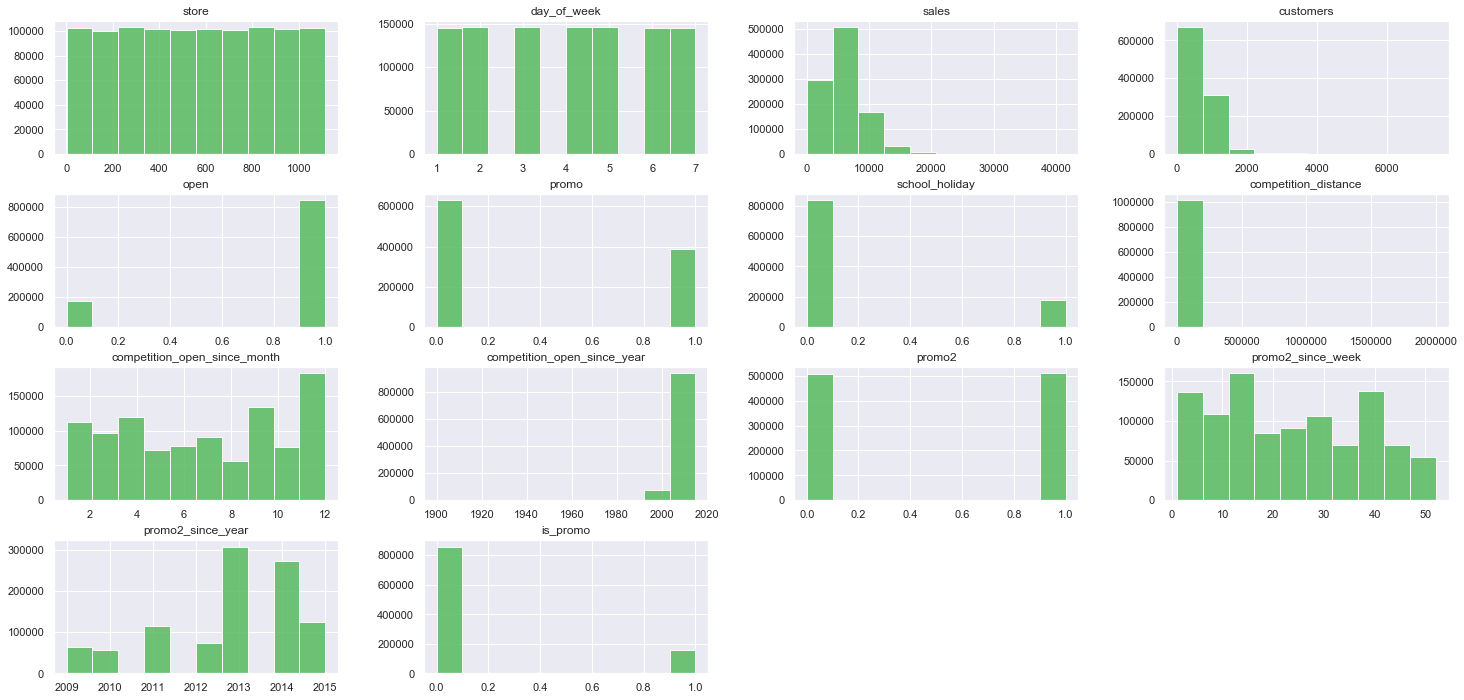

In [19]:
df1[num_cols].hist(bins=10, alpha=0.9, color=green);

#saving figure
plt.savefig('../img/num_attributes.png')

#### 1.8.2 Categorical attributes

In [20]:
#list of categorical attributes
change_df(cat_attributes.apply(lambda x: x.unique().shape[0]))


,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


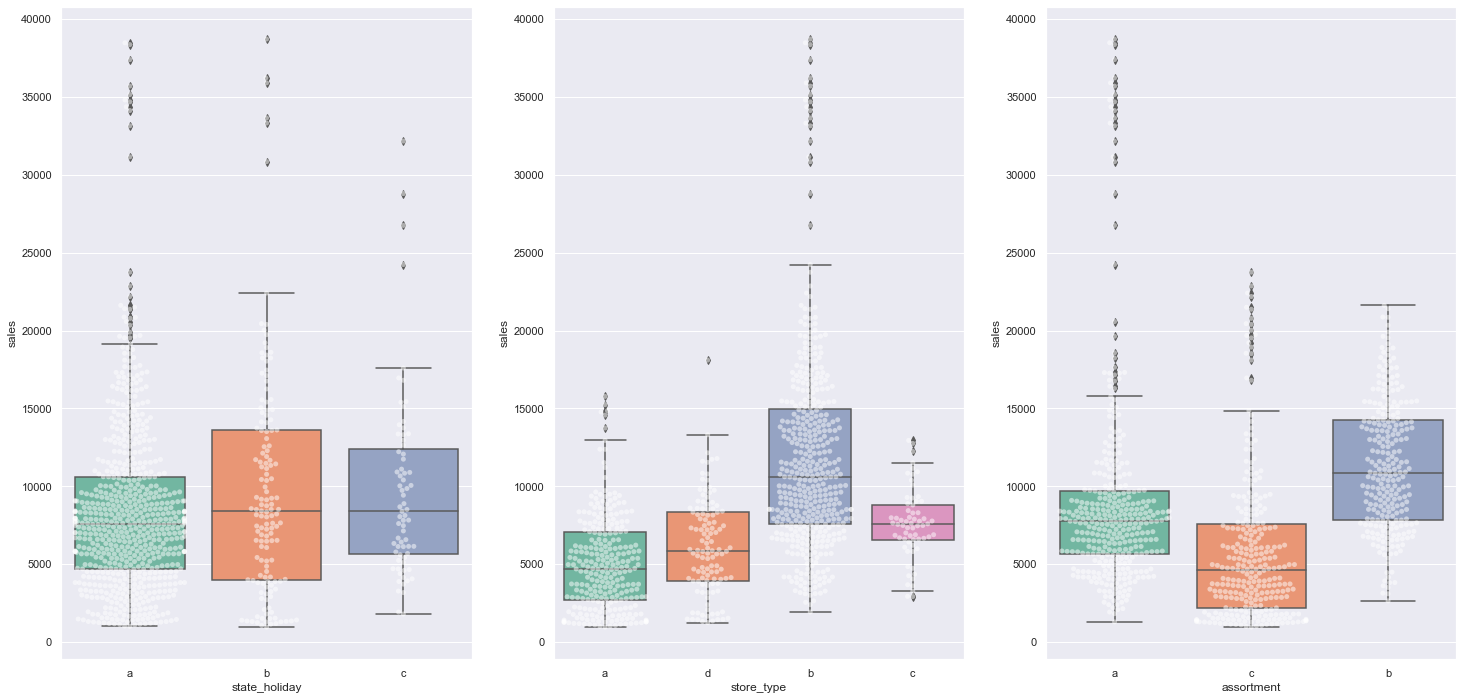

In [21]:
#conditions
#we don't want to see the days when the stores were closed
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# creating subplots
fig, ax = plt.subplots()

plt.subplot(1, 3, 1)
ax = sns.boxplot(x='state_holiday', y='sales', data=aux1, palette='Set2')
ax = sns.swarmplot(x='state_holiday', y='sales', data=aux1, color='white', alpha=0.5)

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='store_type', y='sales', data=aux1, palette='Set2')
ax = sns.swarmplot(x='store_type', y='sales', data=aux1, color='white', alpha=0.5)

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='assortment', y='sales', data=aux1, palette='Set2')
ax = sns.swarmplot(x='assortment', y='sales', data=aux1, color='white', alpha=0.5)

#saving figure
plt.savefig('../img/cat_attributes.png')

# displays plot
plt.show();

## 2.0 FEATURE ENGINEERING

- **Tasks**
    - Dataset Checkpoint
    - Mindmap
    - Hypothesis
    - Feature Engineering To Validate Our Hypothesis

### 2.1 Checkpoint

In [22]:
df2 = df1.copy()

### 2.2 Mind Map

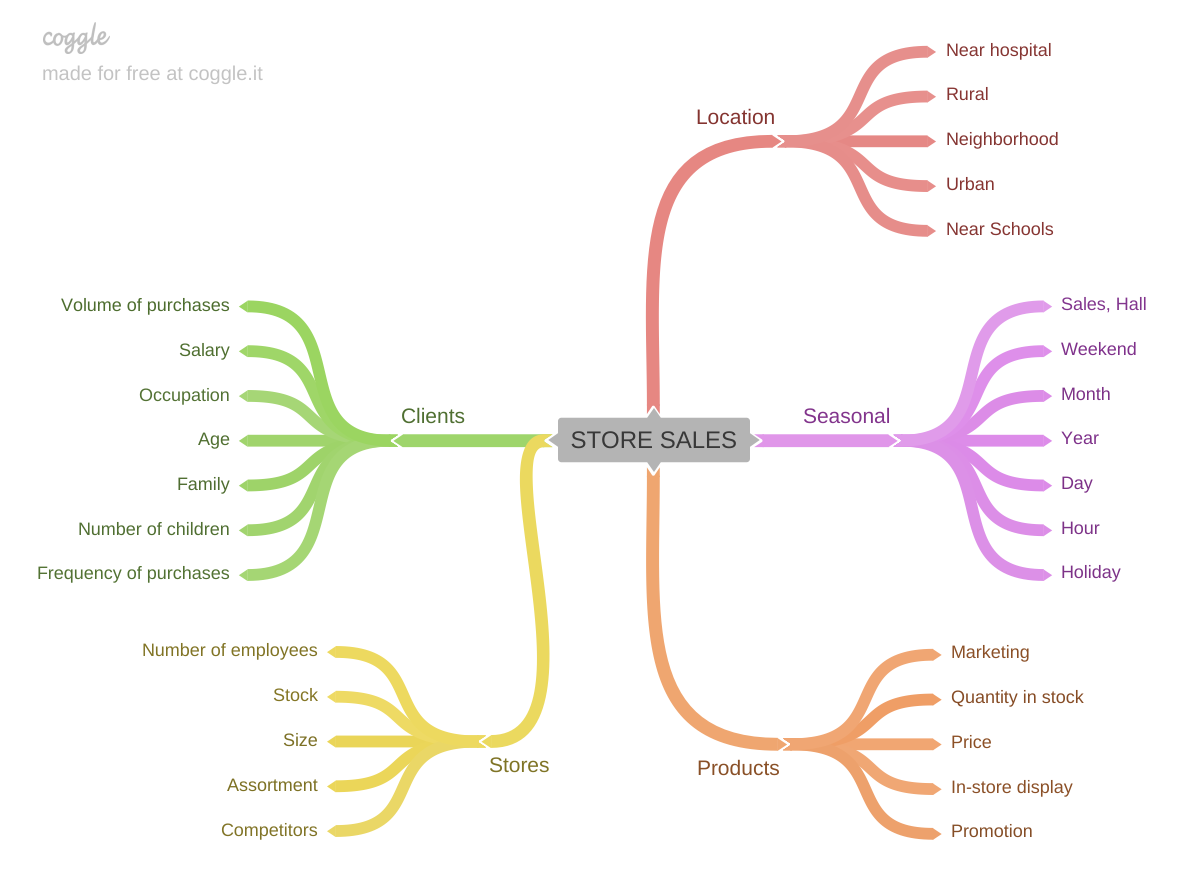

In [23]:
Image('../img/mind_map_hypothesis.png')

### 2.3 Hypothesis creation

#### 2.3.1 Store's hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with more stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5** Stores with closer competitors should sell less.

**6** Stores dealing with competitors for a long time should sell more.

#### 2.3.2 Product's hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with a huge product exposure should sell more.

**3.** Stores with lower priced products should sell more should sell more.

**4.** Stores with more aggressive promotions (bigger discounts), should sell more.

**5.** Stores with active promotions for more time should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

#### 2.3.3 Seasonal's hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more after the 10th of each month.

**4.** Stores should sell more in the second half of the year.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

### 2.4 Hypothesis final list

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more after the 10th of each month.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

### 2.5 Feature Engineering To Validate Our Hypothesis

We'll create these features:
- year
- month
- day
- week of day
- year week

And we'll modify some to be more easy to read in 'state_holiday' and 'assortment'.

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#  year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(
    x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = (
    (df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## 3.0 VARIABLE FILTERING

- **Tasks**
    - Dataset Checkpoint
    - Filtering Rows
    - Filtering Columns

### 3.1 Checkpoint

In [25]:
df3 = df2.copy()

In [26]:
df3.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
987068,1079,1,2013-01-28,6602,603,1,0,regular_day,0,a,basic,16680.000,1,2013,1,37,2009,"Jan,Apr,Jul,Oct",Jan,1,2013,1,28,5,2013-04,2013-01-01,0,2009-09-07,177
570228,134,3,2014-02-05,5025,532,1,1,regular_day,1,a,basic,1200.000,9,2008,0,6,2014,0,Fev,0,2014,2,5,6,2014-05,2008-09-01,66,2014-02-03,0
305283,781,7,2014-10-19,0,0,0,0,regular_day,0,a,basic,630.000,4,2007,0,42,2014,0,Oct,0,2014,10,19,42,2014-41,2007-04-01,91,2014-10-13,0
14014,635,7,2015-07-19,0,0,0,0,regular_day,0,a,basic,27530.000,4,2014,0,29,2015,0,Jul,0,2015,7,19,29,2015-28,2014-04-01,15,2015-07-13,0
260119,437,6,2014-12-06,11180,1120,1,0,regular_day,0,c,extended,430.000,12,2014,1,50,2010,"Jan,Apr,Jul,Oct",Dec,0,2014,12,6,49,2014-48,2014-12-01,0,2010-12-06,208


### 3.2 Filtering Rows

We will remove the data in the columns 'open' and 'sales' that the value is 0, this number means that the store was closed and, because of that, there were no sales.

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.3 Filtering Columns

- Costumer: To use this column, we need to create a model to predict customers. Therefore,right now, it will not help us.

- Open - We've removed all the lines that have the value "0", so there's no variation. This columns won't be usefull.
- Promo_interval / "month_map" - We will remove it because we used it to build columns that will give to us the same information.

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0 EXPLORATORY DATA ANALYSIS

- **Tasks**
    - Do Univariate Analysis
    - Do Bivariate Analysis
    - Do Multivariate Analysis

### 4.1 Checkpoint

In [30]:
df4 = df3.copy()

In [31]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.000,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.000,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.000,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.000,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.000,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 4.2 Univariate Analysis

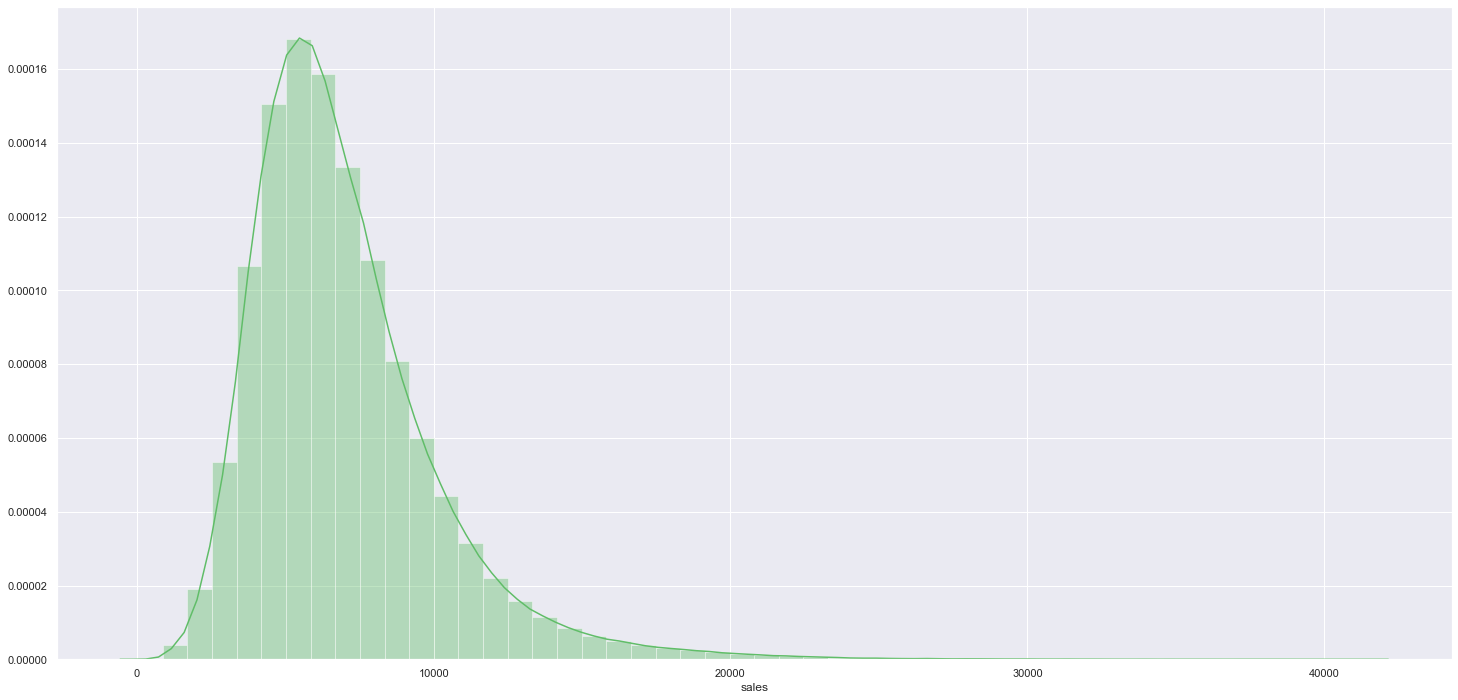

In [32]:
ax = sns.distplot(df4['sales'], color = green)

#saving figure
plt.savefig('../img/sales_dist.png')

In the plot above, we can a see a positive skewness and positive kurtosis on the distribuition. Thinking in the machine learning modelling, it's recommended that the distributions are as close as possible to a normal distribution, in some cases, in many cases, needing a transformation.

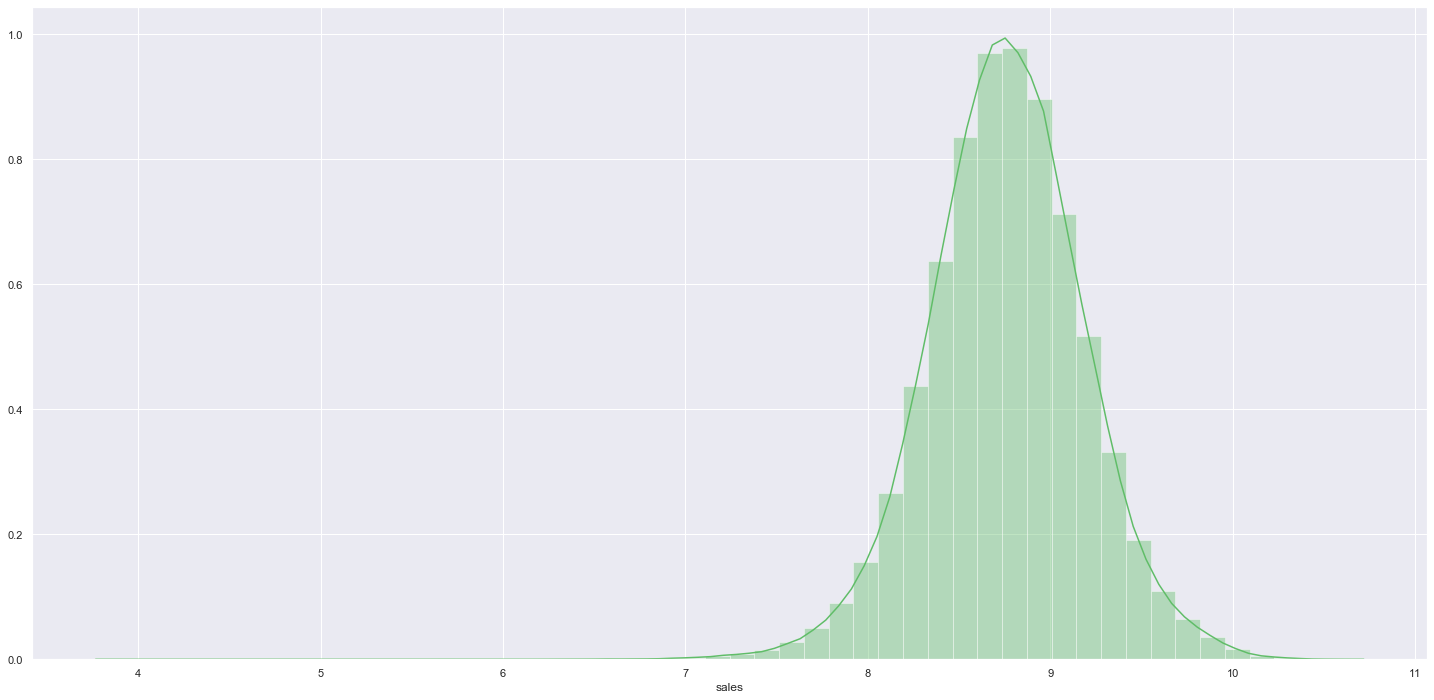

In [33]:
ax = sns.distplot(np.log1p(df4['sales']), color = green)

#saving figure
plt.savefig('../img/sales_dist_logscale.png')

#### 4.2.1 Numerical Variables

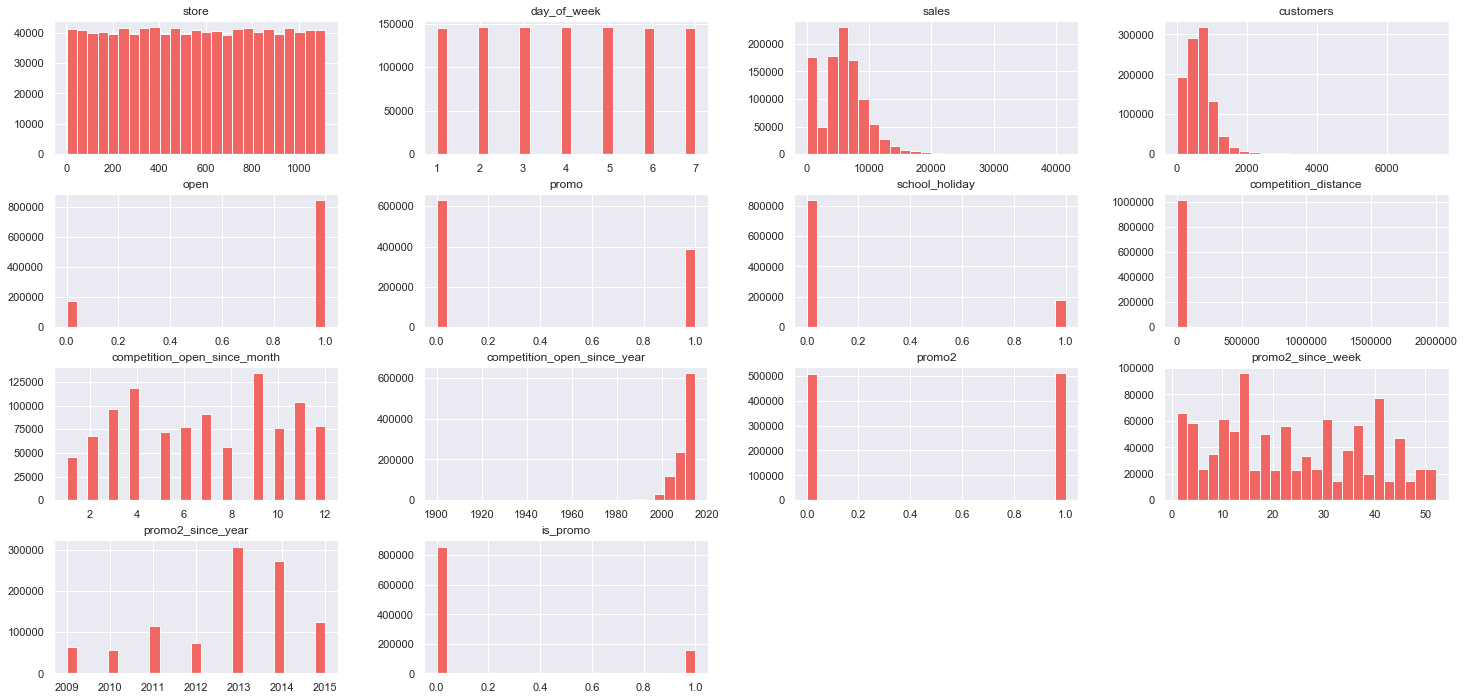

In [34]:
num_attributes.hist(bins=25, alpha=0.9, color=red);

Some information about the variables:
- `competition_distance`: we can see that in this dataset more competitors are near the stores.
- `competition_open_since_month`: we have a seasonal opening. 
- `day_of_week`: we have a uniform distribution, in other words, this variable doesn't too much relevance in a model, alone.
- `competition_open_since_year`: we can see that the opening of new competitors stores had a peak after 2014.
- `day_of_week`: as the stores are open 7 days per week, this distribution are uniform, so... that's not be useful.
- `open`: in this case, when the stores were open - `open == 1` and closed - `open == 0`.
- `promo`: stores that weren't in regular promotion `promo == 0` and those who were `promo == 1`.
- `promo2`: we don't have more information about promo and promo2, but these 2 have a similar variation and information, stores that weren't in regular promotion `promo == 0` and those who were `promo == 1`.
- `sales`: the most part of sales were in the range of 0 - $10,000.
- `store`: unique Id for each store, there is no real useful information to us. 


#### 4.2.2 Categorical Variables

In [35]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [36]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

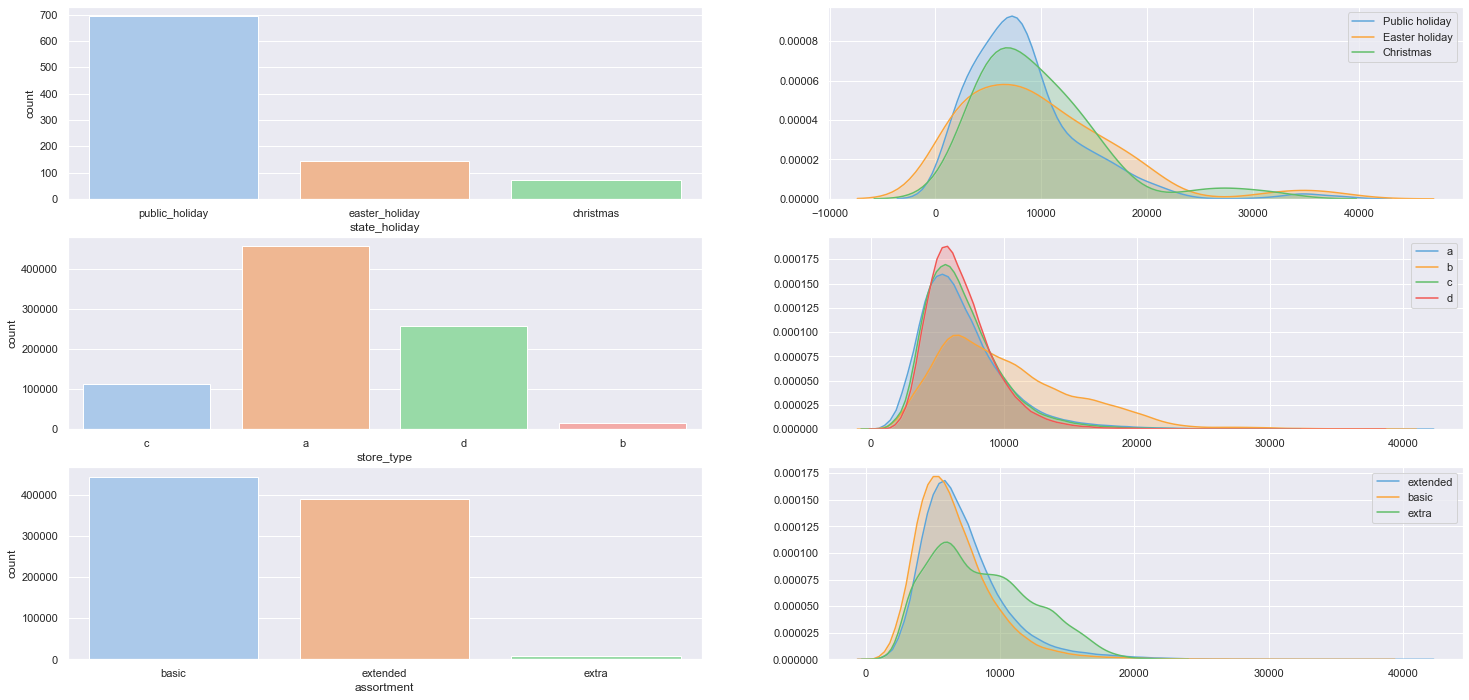

In [37]:
# creating subplots
fig, ax = plt.subplots()

# state_holiday
without_regular_day = df4[df4['state_holiday'] != 'regular_day']

# ---

plt.subplot(3, 2, 1)
ax = sns.countplot(without_regular_day['state_holiday'], palette = 'pastel')

plt.subplot(3, 2, 2)
ax = sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], 
                          label = 'Public holiday', shade = True, color = blue)
ax = sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
                          label = 'Easter holiday', shade = True, color = orange)
ax = sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],
                          label = 'Christmas', shade = True, color = green)

# ---

# store_type
plt.subplot(3, 2, 3)
ax = sns.countplot(df4['store_type'], palette = 'pastel')

plt.subplot(3, 2, 4)
ax = sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],
                          label = 'a', shade=True, color=blue)
ax = sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],
                         label = 'b', shade = True, color = orange)
ax = sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],
                          label = 'c', shade = True, color = green)
ax = sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],
                 label = 'd', shade = True, color = red)

# ---

# assortment

plt.subplot(3, 2, 5)
ax = sns.countplot(df4['assortment'], palette = 'pastel')

plt.subplot(3, 2, 6)
ax = sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
                         label = 'extended', shade = True, color = blue)
ax = sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
                         label = 'basic', shade = True, color = orange)
ax = sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
                         label = 'extra', shade = True, color = green)

#saving figure
plt.savefig('../img/cat_attributes_full.png')

### 4.3 Bivariate Analysis

#### H1. Stores with a larger assortment should sell more.
**FALSE** Stores with a LARGER ASSORTMENT sell LESS.

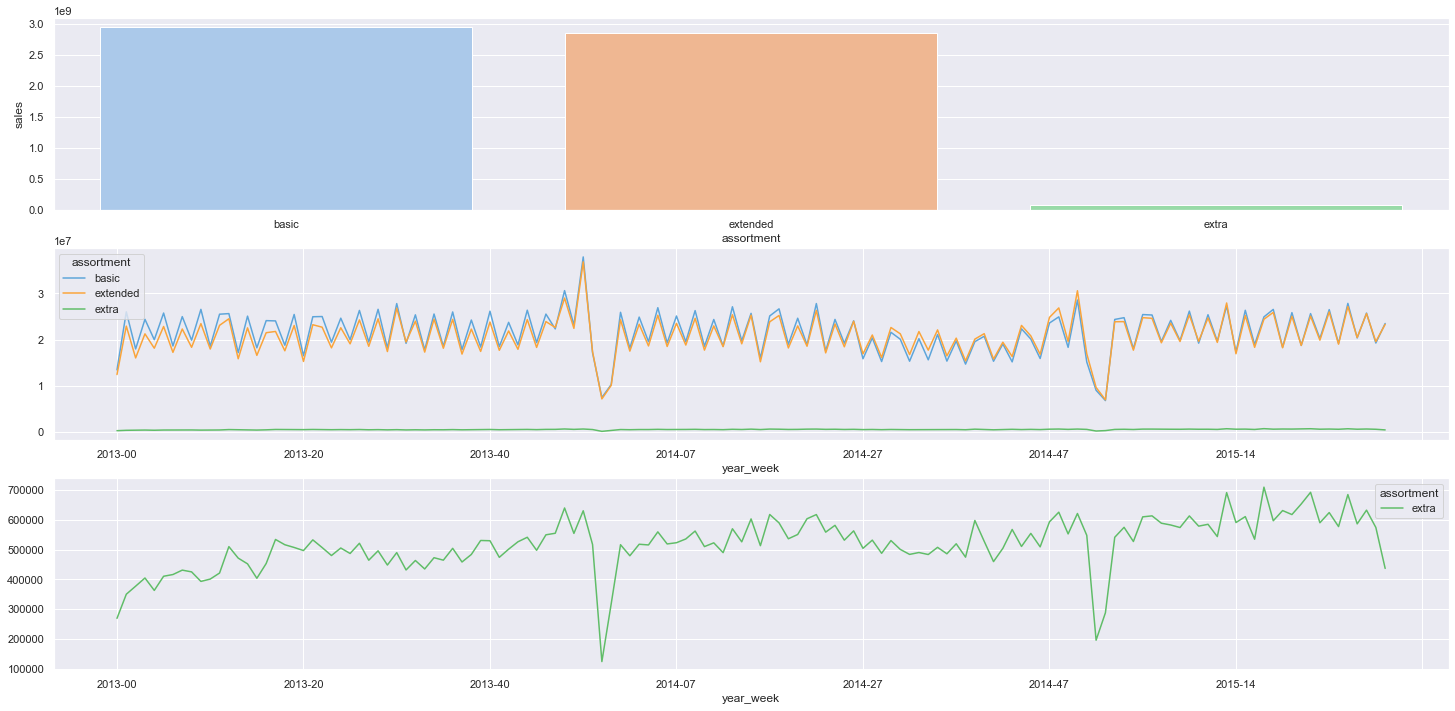

In [38]:
# creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# ---

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
ax = sns.barplot(x='assortment', y='sales', palette='pastel', data=aux1, ax = ax1);

# ---

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax2, color=(blue, orange, green));

# ---

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax3, color=green);

#saving figure
plt.savefig('../img/hyp1.png')

#### **H2.** Stores with closer competitors should sell less.
**FALSE** Stores with CLOSER COMPETITORS sell MORE.

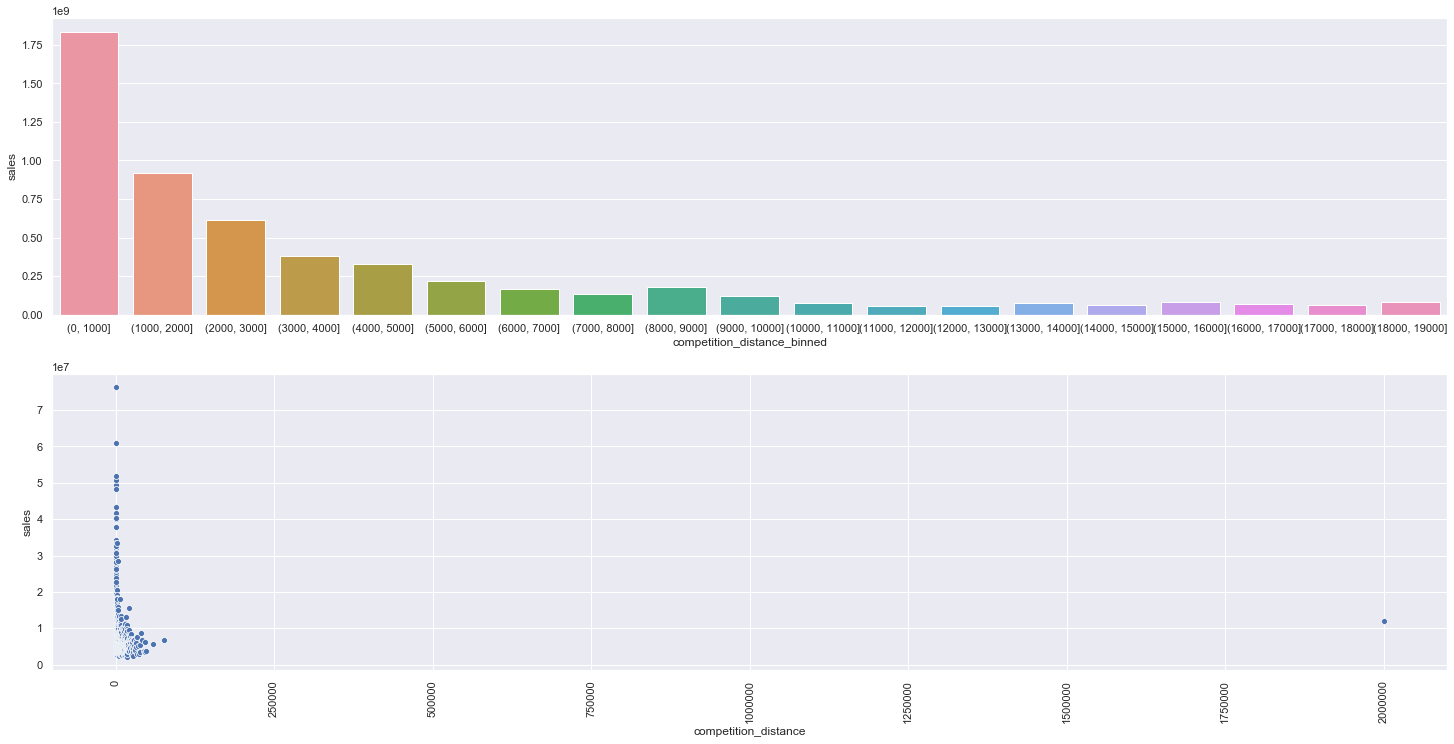

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# ---
fig, (ax1, ax2) = plt.subplots(2,1)

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(
    aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned').sum().reset_index()
plt.xticks (rotation = 90)

# barplot
ax = sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2, ax = ax1);

# scatterplot
ax = sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1, ax = ax2);

#saving figure
plt.savefig('../img/hyp2.png')

#### **H3.** Stores with long time competitors should sell more.
**FALSE** Stores with LONG TIME COMPETITORS sell LESS.

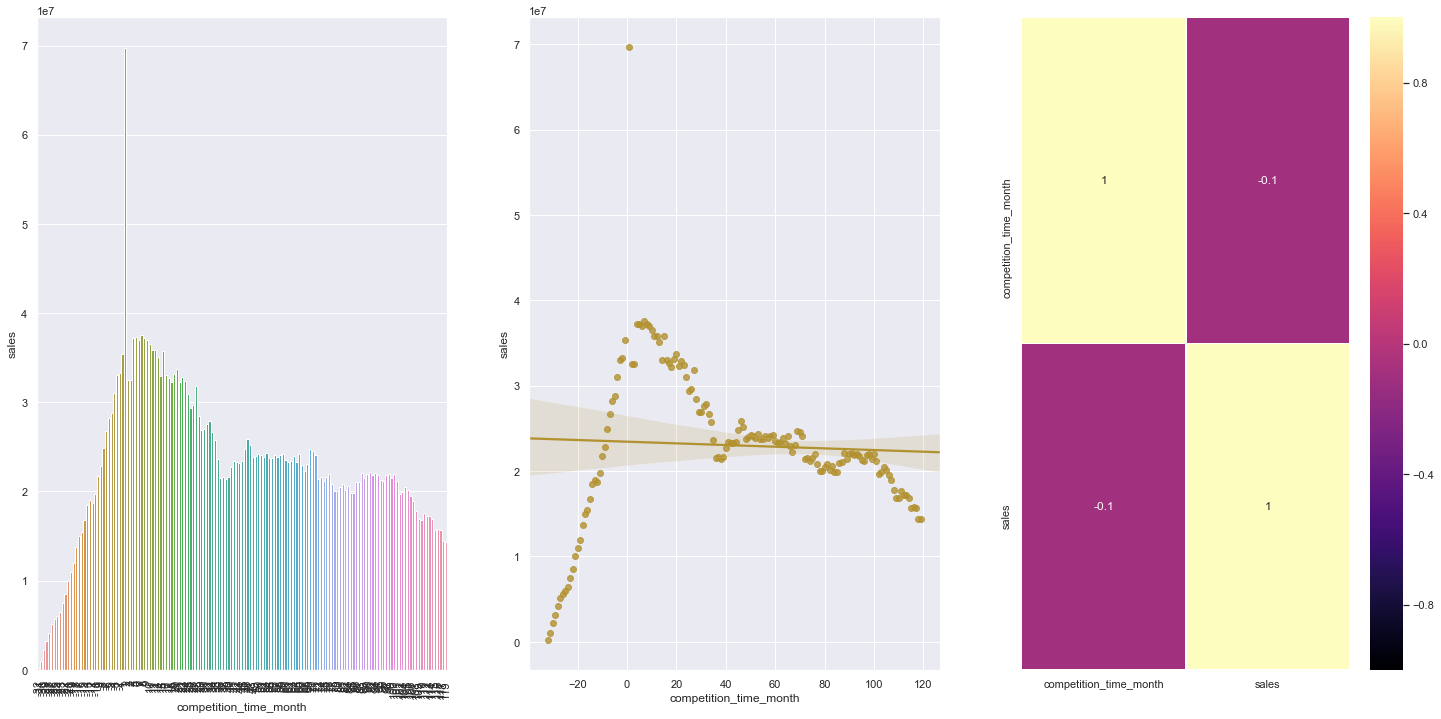

In [40]:
# creating subplots
fig, ax = plt.subplots()

# ---
# barplot
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0)]
ax = sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

# regplot
plt.subplot(1, 3, 2)
ax = sns.regplot( x = 'competition_time_month', y = 'sales', data = aux2, color = brown);

# heatmap
plt.subplot(1, 3, 3)
ax = sns.heatmap(aux1.corr(method = 'pearson'), linewidths = .5, vmin = -1, vmax = 1, annot = True, cmap = 'magma')

#saving figure
plt.savefig('../img/hyp3.png')

#### **H4.** Stores with active promotions for longer should sell more.
**FALSE** Stores with ACTIVE PROMOTIONS for longer sell LESS, after a certain time.

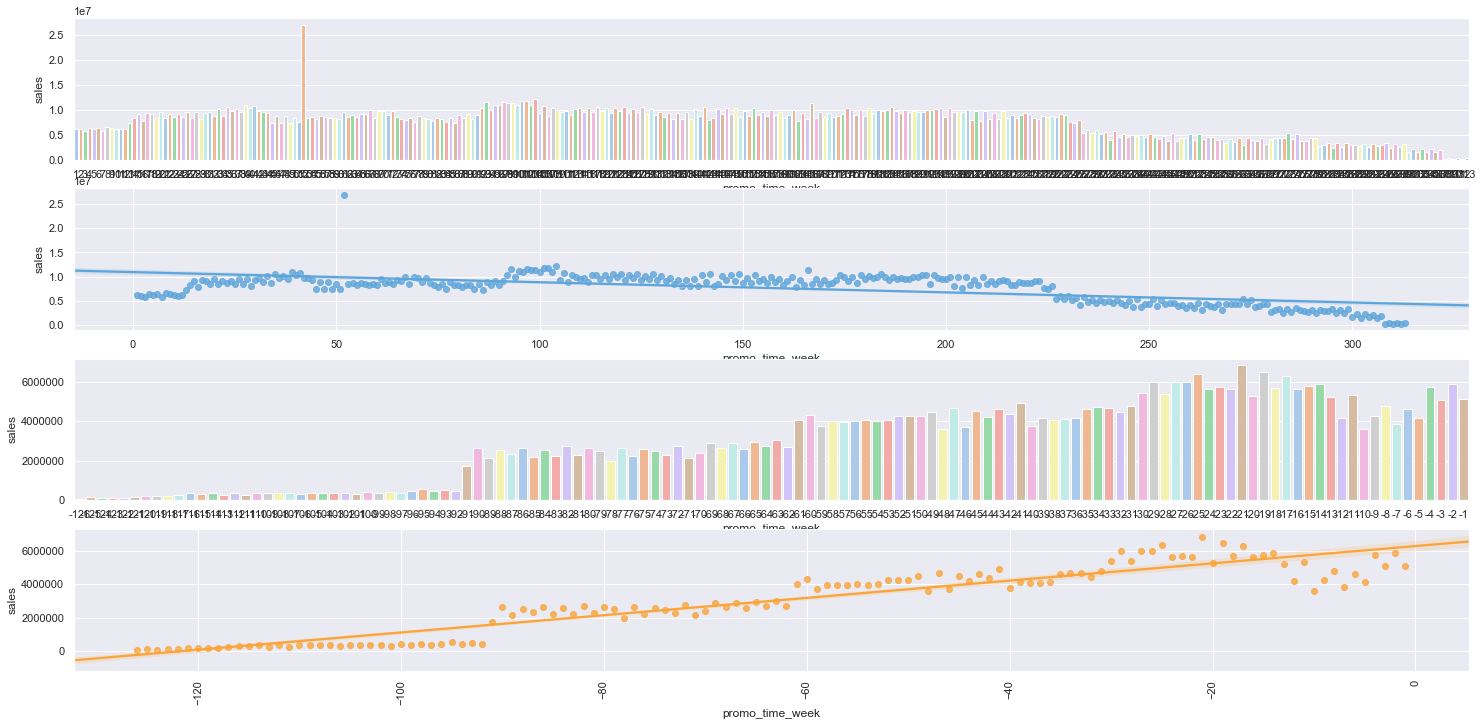

In [41]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# ---

# creating subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

# barplot 1
aux2 = aux1[aux1['promo_time_week'] > 0]  # promo extended
sns.barplot(data = aux2, x = 'promo_time_week', y ='sales', palette ='pastel', ax = ax1);
plt.xticks(rotation=90)

# regplot 1
sns.regplot(data = aux2, x = 'promo_time_week', y = 'sales', color = blue, ax = ax2);

# barplot 2
aux3 = aux1[aux1['promo_time_week'] < 0]  # promo regular
sns.barplot(data = aux3, x = 'promo_time_week', y = 'sales', palette = 'pastel', ax = ax3);
plt.xticks(rotation=90)

# regplot 2
sns.regplot(data=aux3, x='promo_time_week', y='sales', color = orange, ax = ax4);

#saving figure
plt.savefig('../img/hyp4a.png')

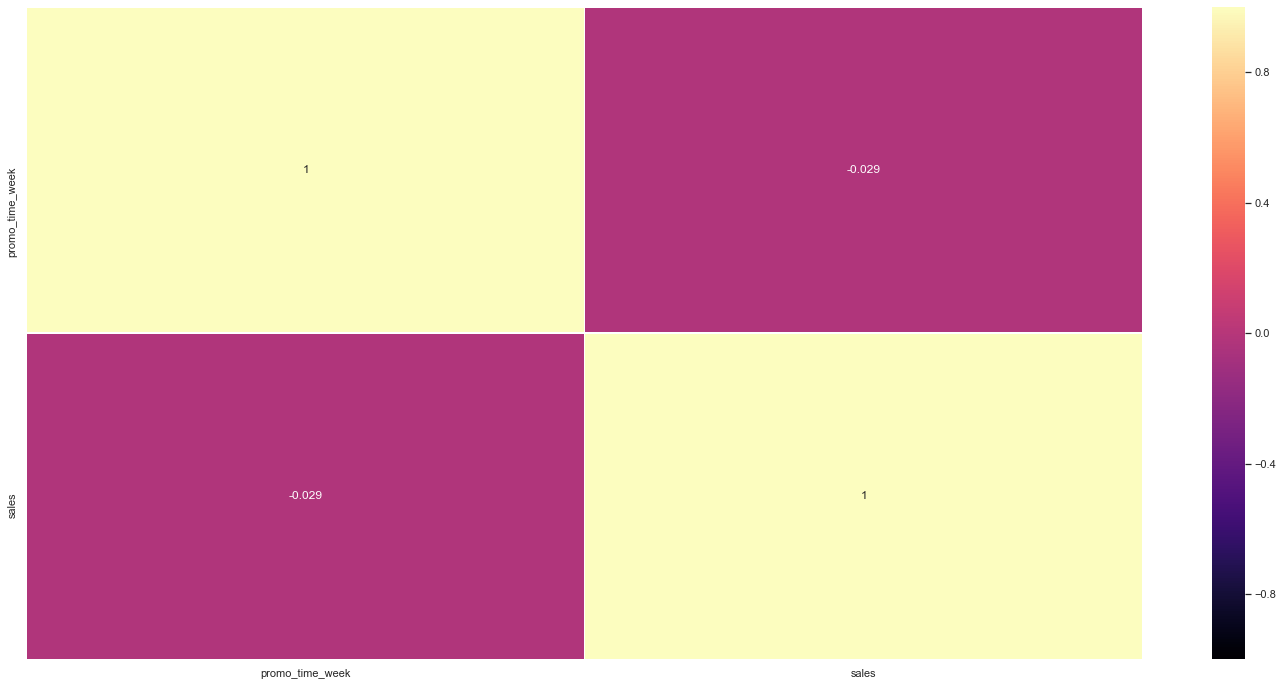

In [42]:
sns.heatmap(aux1.corr(method = 'pearson'), linewidths = .5, vmin = -1, vmax = 1, annot = True, cmap = 'magma');

#saving figure
plt.savefig('../img/hyp4b.png')

#### **H5.** Stores with more active promotions should sell more.
**FALSE** Stores with more ACTIVE PROMOTIONS sell LESS.

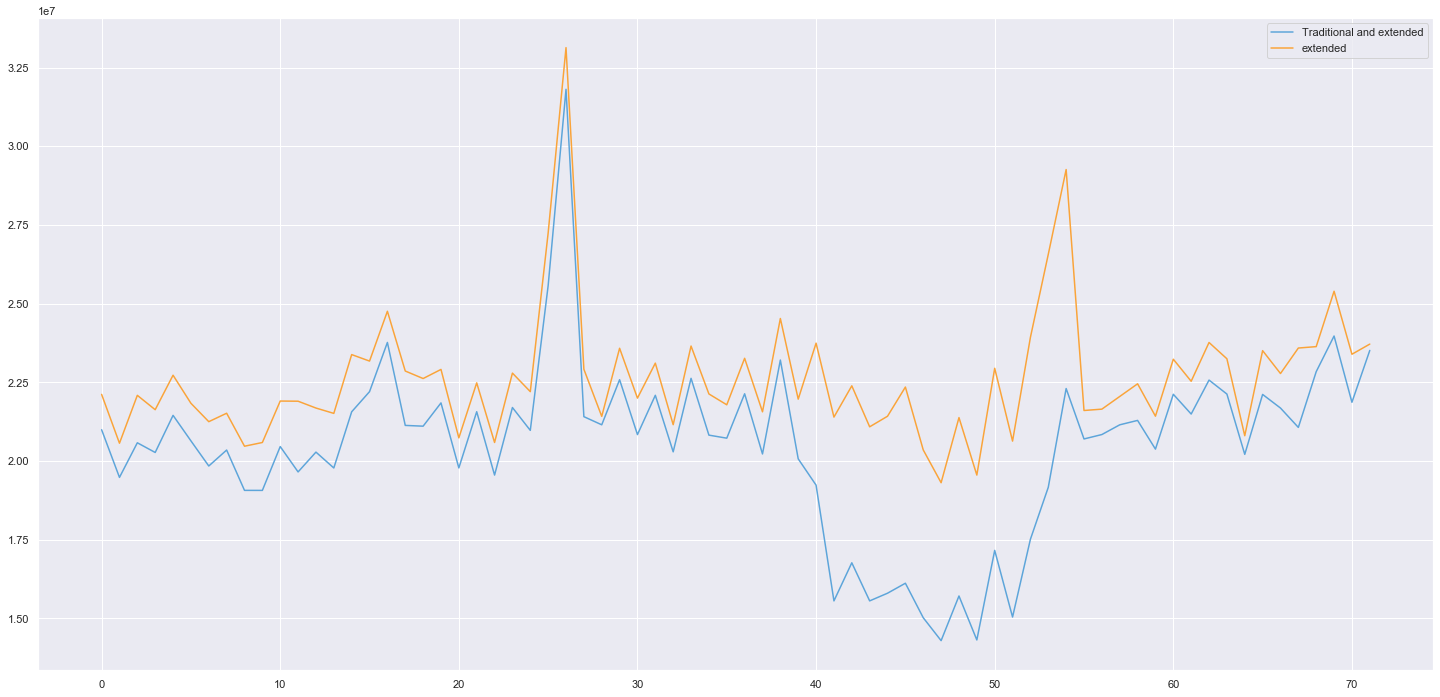

In [43]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# plot 1
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(color = blue)

# plot 2
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot(ax = ax, color = orange)
ax.legend(labels=['Traditional and extended', 'extended']);

#saving figure
plt.savefig('../img/hyp5.png')

#### **H6.** Stores open during christmas should sell more.
**FALSE** Stores OPEN DURING CHRISTMAS sell LESS.

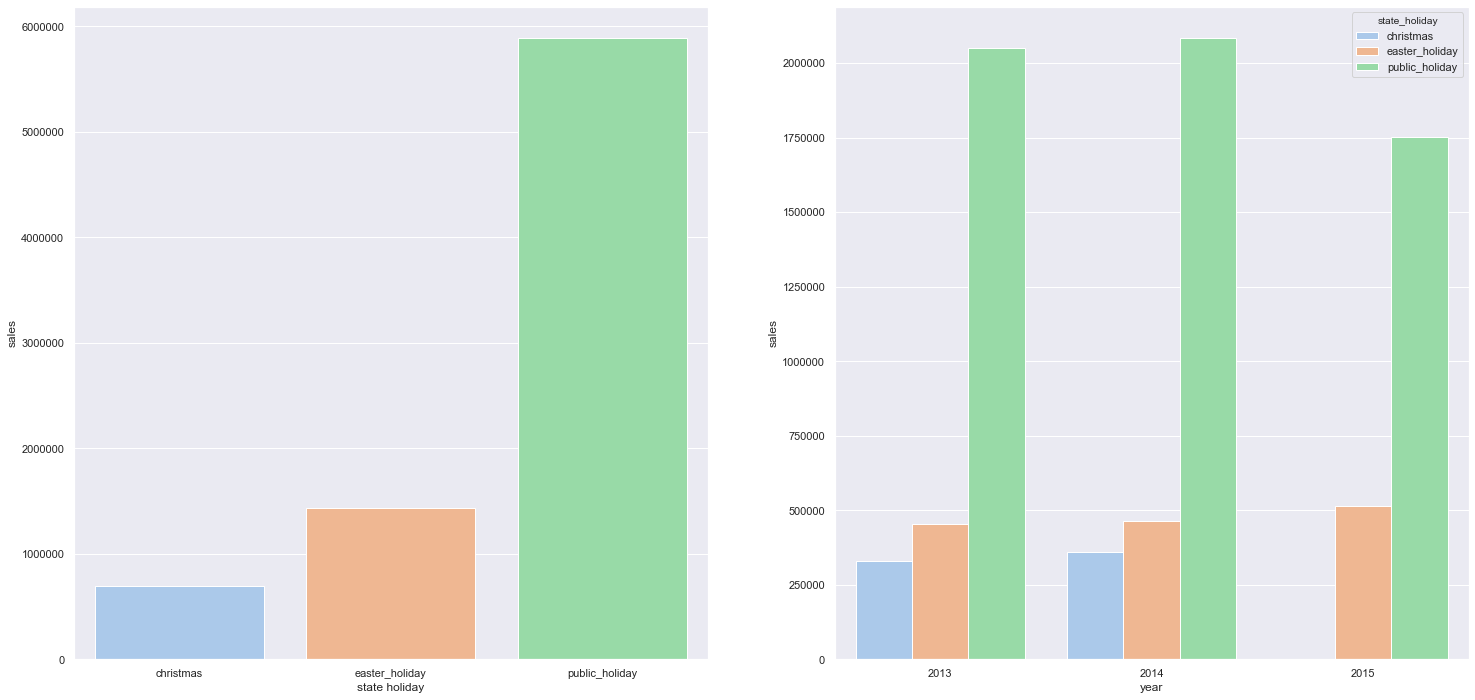

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']

# creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot 1
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
ax = sns.barplot(x = 'state_holiday', y = 'sales', palette = 'pastel', data = aux1, ax = ax1).set(
xlabel='state holiday', ylabel='sales');

# plot 2
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
ax = sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', palette = 'pastel', data = aux2, ax = ax2);

#saving figure
plt.savefig('../img/hyp6.png')

#### **H7.** Stores should sell more over the years.
**FALSE** Stores sell LESS OVER THE YEARS.

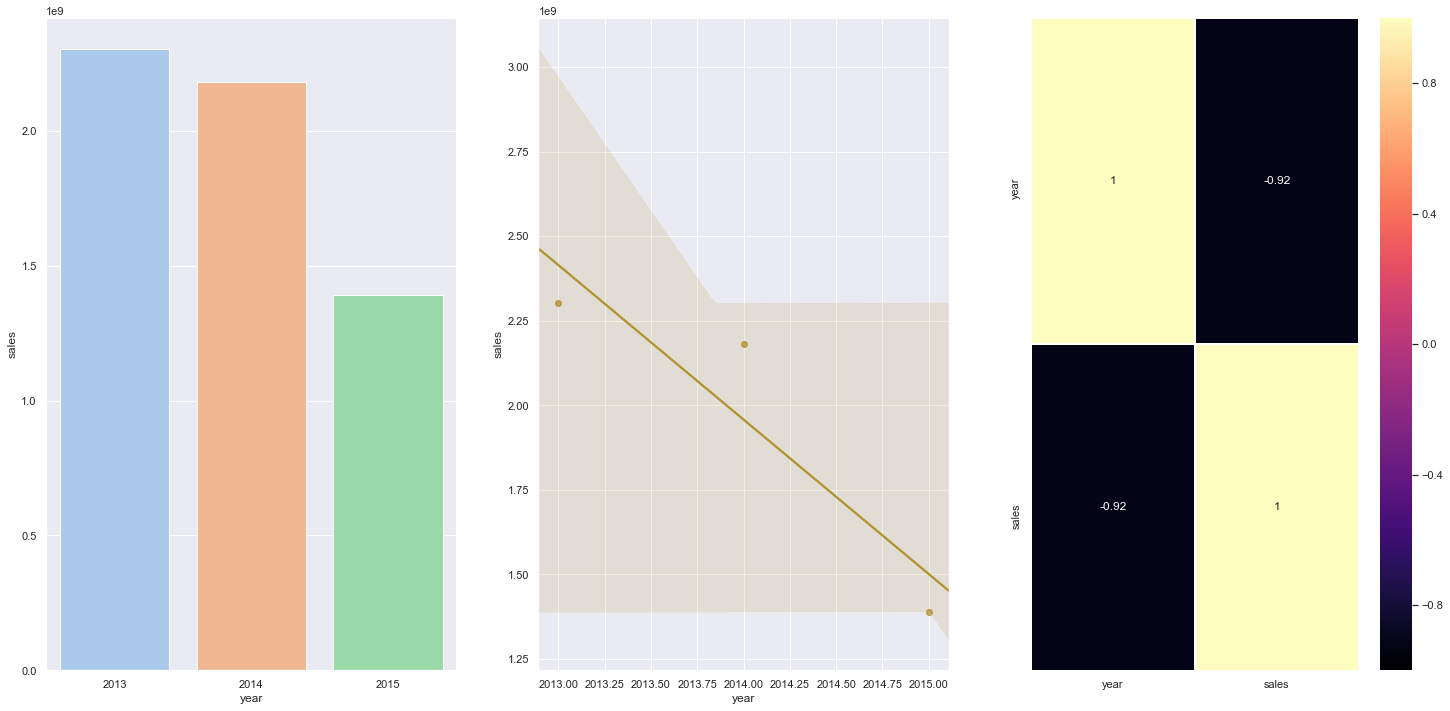

In [45]:
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

# creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# barplot
ax = sns.barplot(x = 'year', y = 'sales', palette = 'pastel', data = aux, ax = ax1)

# regplot
ax = sns.regplot(x = 'year', y = 'sales', color = brown, data = aux, ax = ax2)

# heatmap
ax = sns.heatmap( aux.corr(method = 'pearson'), linewidths = .5,
           vmin = -1, vmax = 1, annot = True, cmap = 'magma', ax = ax3);

#saving figure
plt.savefig('../img/hyp7.png')

#### **H8.** Stores should sell more in the second half of the year.
**FALSE** Stores sell LESS in the SECOND HALF OF THE YEAR.

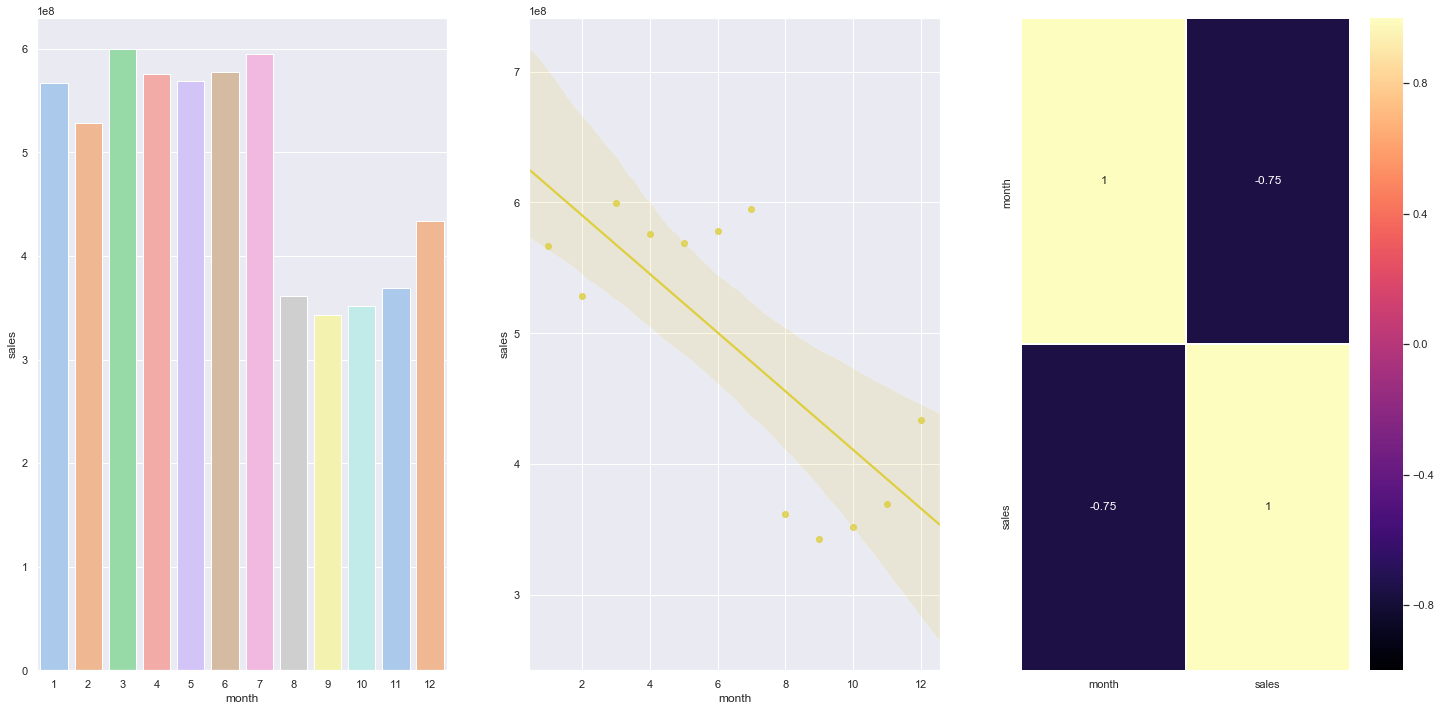

In [46]:
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

# creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# barplot
ax = sns.barplot(x = 'month', y = 'sales', data = aux, palette = 'pastel', ax = ax1);

# regplot
ax = sns.regplot(x = 'month', y = 'sales', color = yellow, data = aux, ax = ax2);

# heatmap
ax = sns.heatmap(aux.corr(method = 'pearson'), linewidths = .5, vmin = -1, vmax = 1, 
                 annot = True, cmap='magma', ax = ax3);

#saving figure
plt.savefig('../img/hyp8.png')

#### **H9.** Stores should sell more after the 10th of each month.
**TRUE** Stores sell more after the 10th of each month.

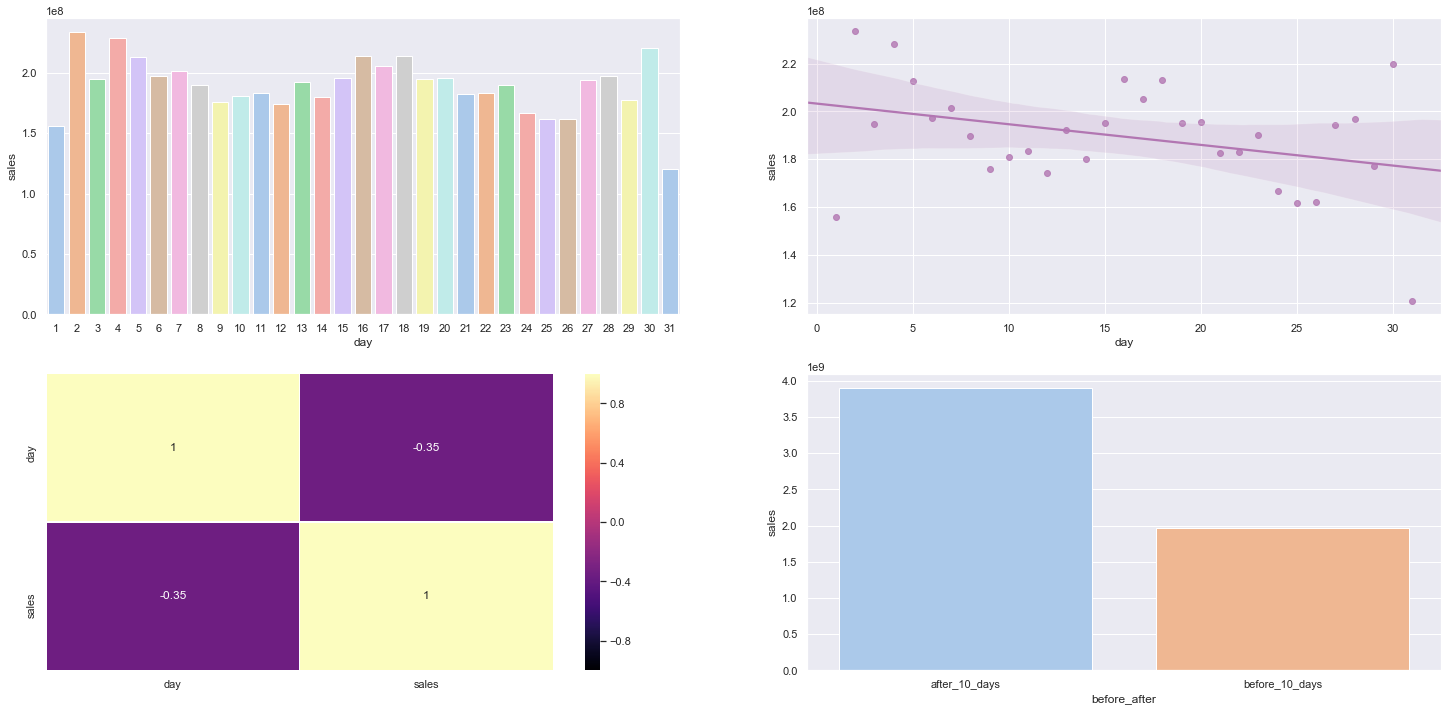

In [47]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

#creating subplots
fig, ax = plt.subplots()

# barplot
plt.subplot(2, 2, 1)
ax = sns.barplot(x = 'day', y = 'sales', data = aux1, palette = 'pastel');

# regplot
plt.subplot(2, 2, 2)
ax = sns.regplot(x = 'day', y = 'sales',data = aux1, color = purple);

#heatmap
plt.subplot(2, 2, 3)
ax = sns.heatmap(aux1.corr(method='pearson'), linewidths = .5, vmin = -1, vmax = 1, annot = True,
            cmap = 'magma');

# barplot 2
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' 
                                         if x <= 10 
                                         else 'after_10_days')

aux2 =aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
ax = sns.barplot(x = 'before_after', y = 'sales', data = aux2, palette = 'pastel');

#saving figure
plt.savefig('../img/hyp9.png')

#### **H10.** Stores should sell less on weekends. 
**TRUE** Stores should sell less on weekends. 

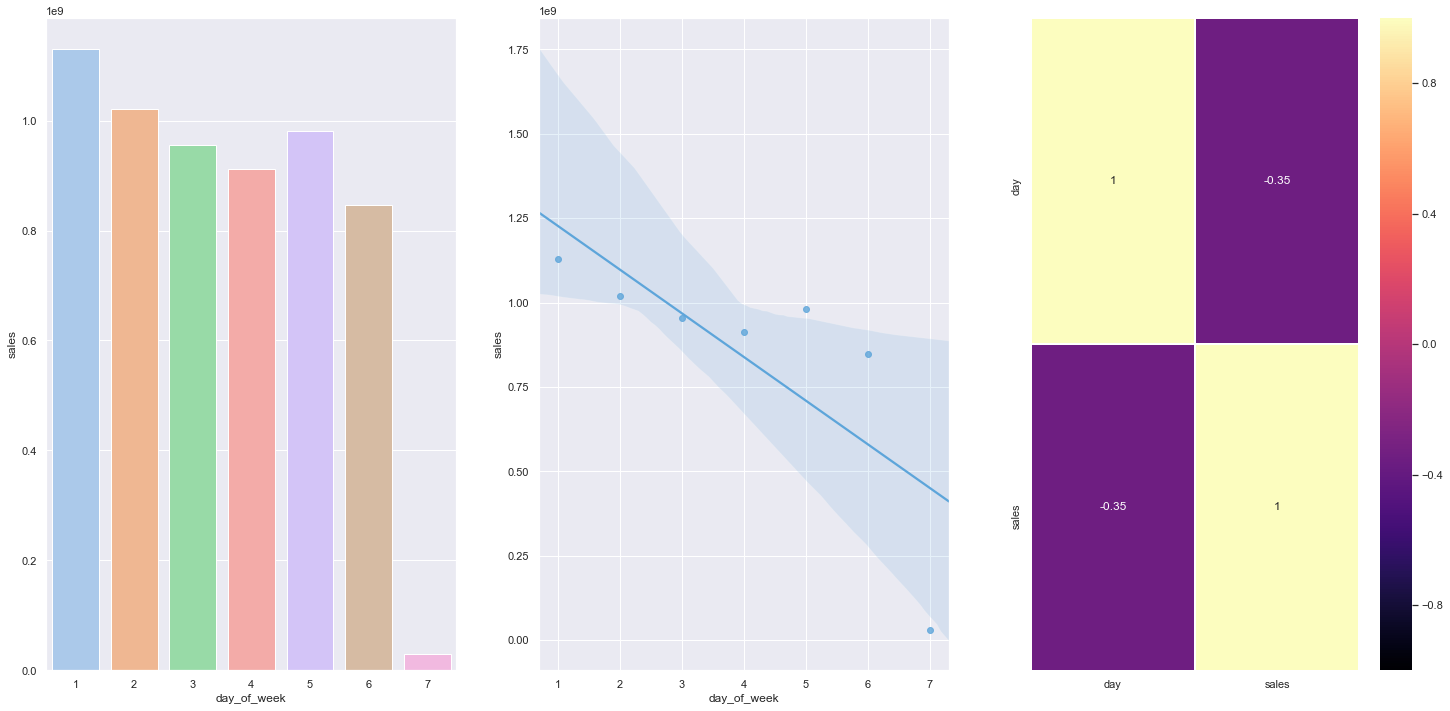

In [48]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# barplot
ax = sns.barplot(x = 'day_of_week', y = 'sales', data = aux, palette = 'pastel', ax = ax1);

# regplot
ax = sns.regplot(x = 'day_of_week', y = 'sales', data = aux, color = blue, ax = ax2);

# heatmap
ax =sns.heatmap(aux1.corr(method='pearson'), linewidths = .5, vmin = -1, vmax = 1, annot = True,
                cmap= 'magma', ax = ax3);

#saving figure
plt.savefig('../img/hyp10.png')

#### **H11.** Stores should sell less during school holidays.
**TRUE** Stores sell less during school holidays, except on July e August.

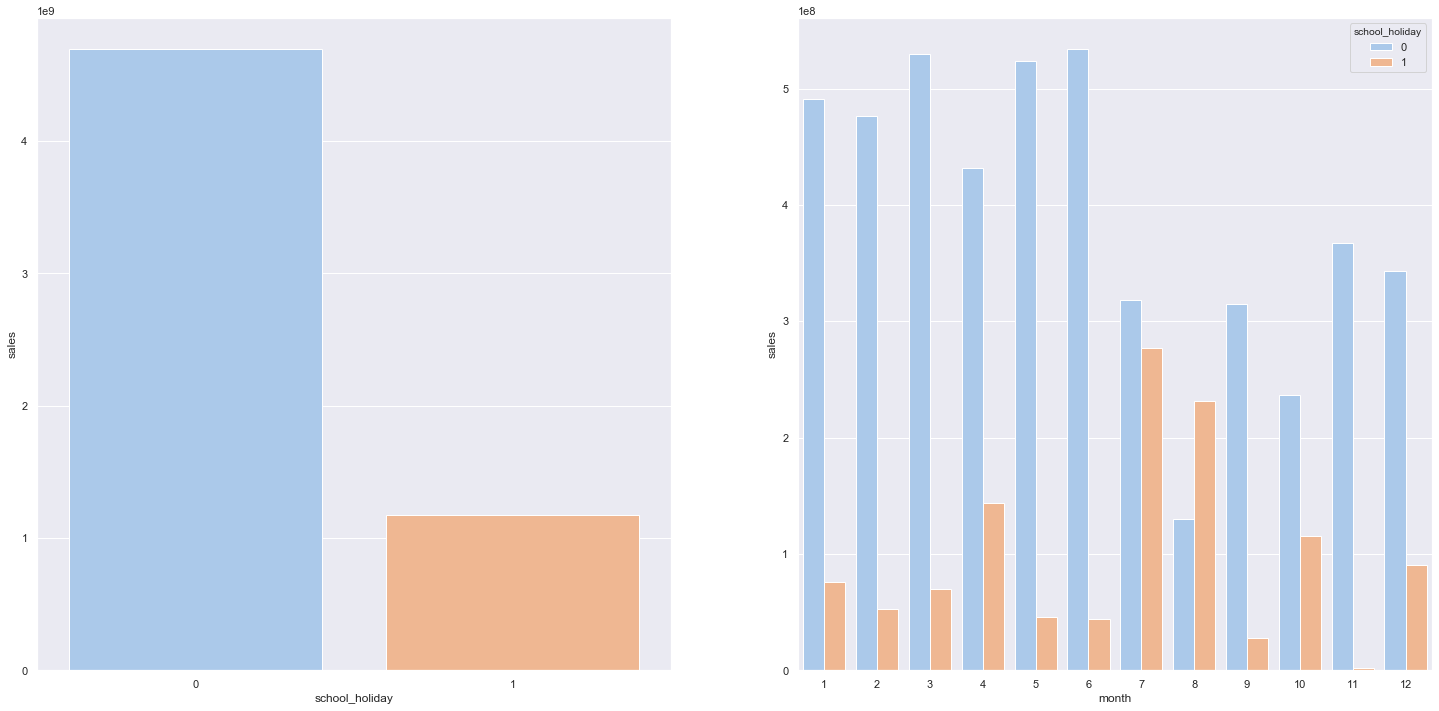

In [49]:
# creating subplots
fig_h12, (ax1, ax2) = plt.subplots(1, 2)

# barplot 1
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

ax = sns.barplot(x = 'school_holiday', y = 'sales', data = aux1, palette = 'pastel', ax = ax1);

#barplot 2
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()

sns.barplot(x = 'month', y = 'sales', data = aux2, hue = 'school_holiday', palette = 'pastel', ax = ax2);

#saving figure
plt.savefig('../img/hyp11.png')

#### 4.3.1 Hypothesis Resume

In [50]:
resume = [
    ['Hypothesis', 'Conclusion', 'Relevance'],
    ['1', 'False', 'Low'],
    ['2', 'False', 'Med'],
    ['3', 'False', 'Med'],
    ['4', 'False', 'Low'],
    ['5', 'False', 'Low'],
    ['6', 'False', 'Med'],
    ['7', 'False', 'High'],
    ['8', 'False', 'High'],
    ['9', 'True', 'High'],
    ['10', 'True', 'High'],
    ['11', 'True', 'Low'],
]
print(tabulate(resume, headers='firstrow'))

  Hypothesis  Conclusion    Relevance
------------  ------------  -----------
           1  False         Low
           2  False         Med
           3  False         Med
           4  False         Low
           5  False         Low
           6  False         Med
           7  False         High
           8  False         High
           9  True          High
          10  True          High
          11  True          Low


### 4.4 Multivariate Analysis

#### 4.4.1 Numerical Attributes

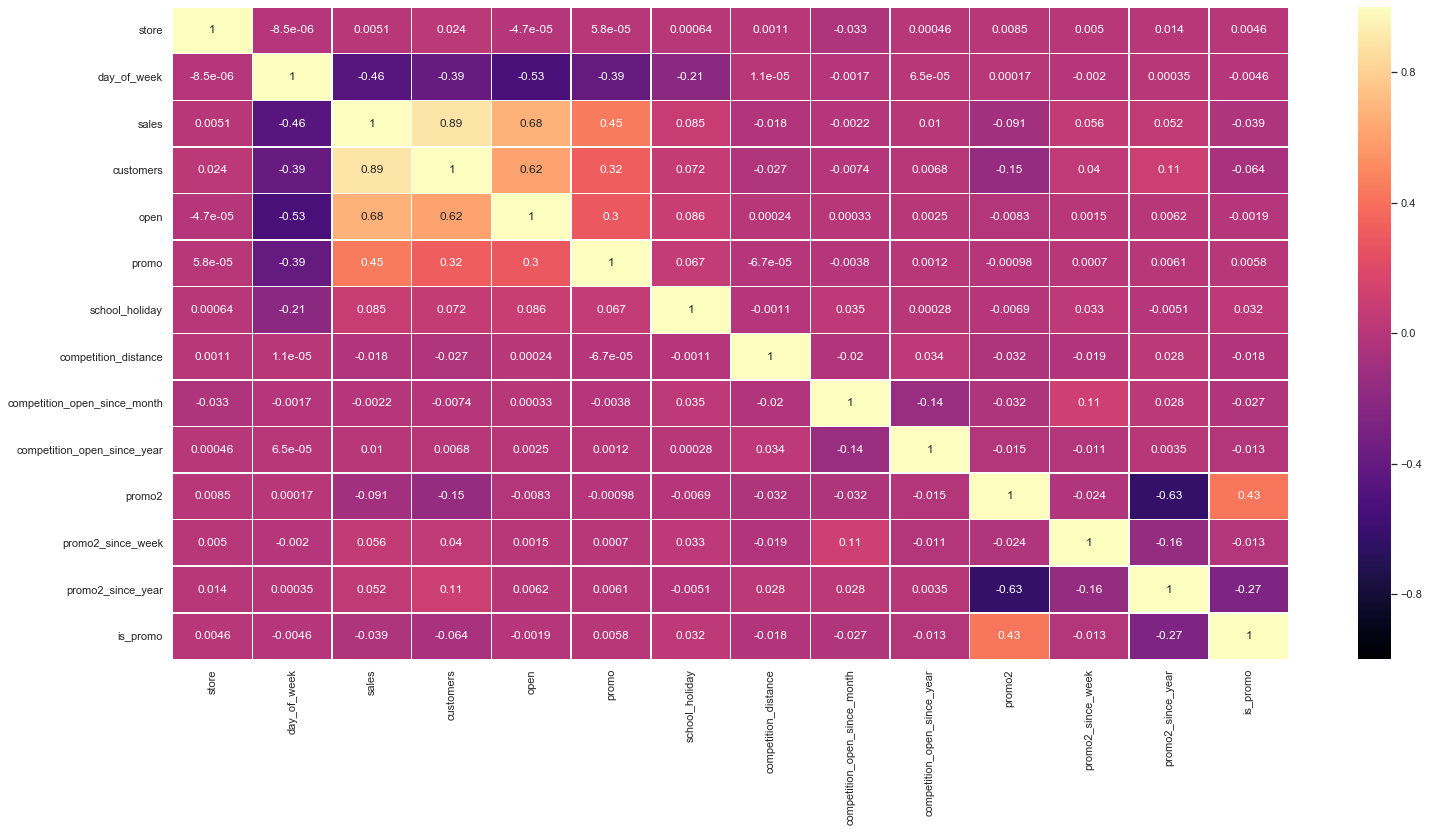

In [51]:
correlation = num_attributes.corr(method='pearson')
ax = sns.heatmap(correlation, linewidths=.5, vmin=-1, vmax=1, annot=True, cmap="magma")

#saving figure
plt.savefig('../img/corr_num_attributes.png')

#### 4.4.2 Categorical Attributes

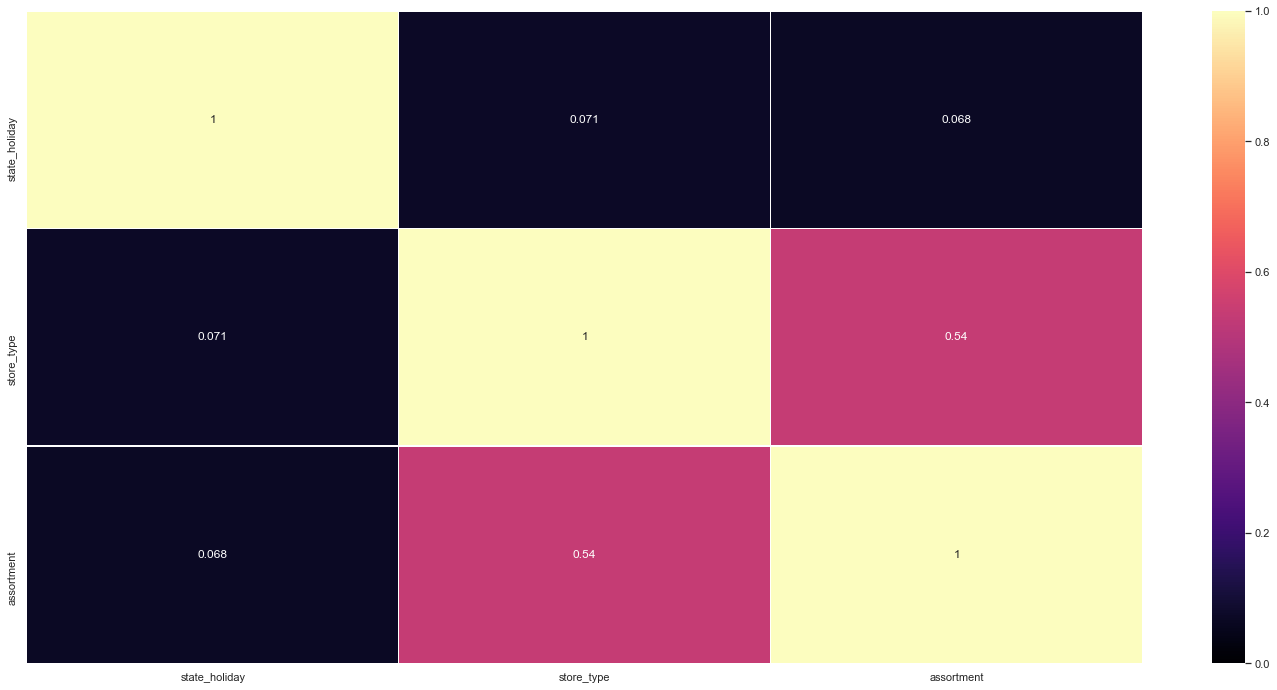

In [52]:
# only categorical data
c = df4.select_dtypes(include='object')

# Cramer's V calculation
c1 = cramers_v(c['state_holiday'], c['state_holiday'])
c2 = cramers_v(c['state_holiday'], c['store_type'])
c3 = cramers_v(c['state_holiday'], c['assortment'])

c4 = cramers_v(c['store_type'], c['state_holiday'])
c5 = cramers_v(c['store_type'], c['store_type'])
c6 = cramers_v(c['store_type'], c['assortment'])

c7 = cramers_v(c['assortment'], c['state_holiday'])
c8 = cramers_v(c['assortment'], c['store_type'])
c9 = cramers_v(c['assortment'], c['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [c1, c2, c3], 'store_type': [
                 c4, c5, c6], 'assortment': [c7, c8, c9]})
d = d.set_index(d.columns)

ax = sns.heatmap(d, linewidths=.5, vmin=0, vmax=1, annot=True, cmap="magma");

#saving figure
plt.savefig('../img/corr_cat_attributes.png')

## 5.0 DATA PREPARATION

- **Tasks**
    - Select best data preparation for each case
    - Rescaling
        - Robust Scaler
        - MinMaxScaler
    - Encoding
        - Transformation of the variable response
        - Transformation of nature.

### 5.1 Checkpoint

In [53]:
df5 = df4.copy()

### 5.2 Rescaling

In [54]:
aux = df5.select_dtypes(include = ['int64','float64'])
aux.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.000,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.000,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.000,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.000,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.000,4,2015,0,31,2015,0,2015,7,31,31,4,0


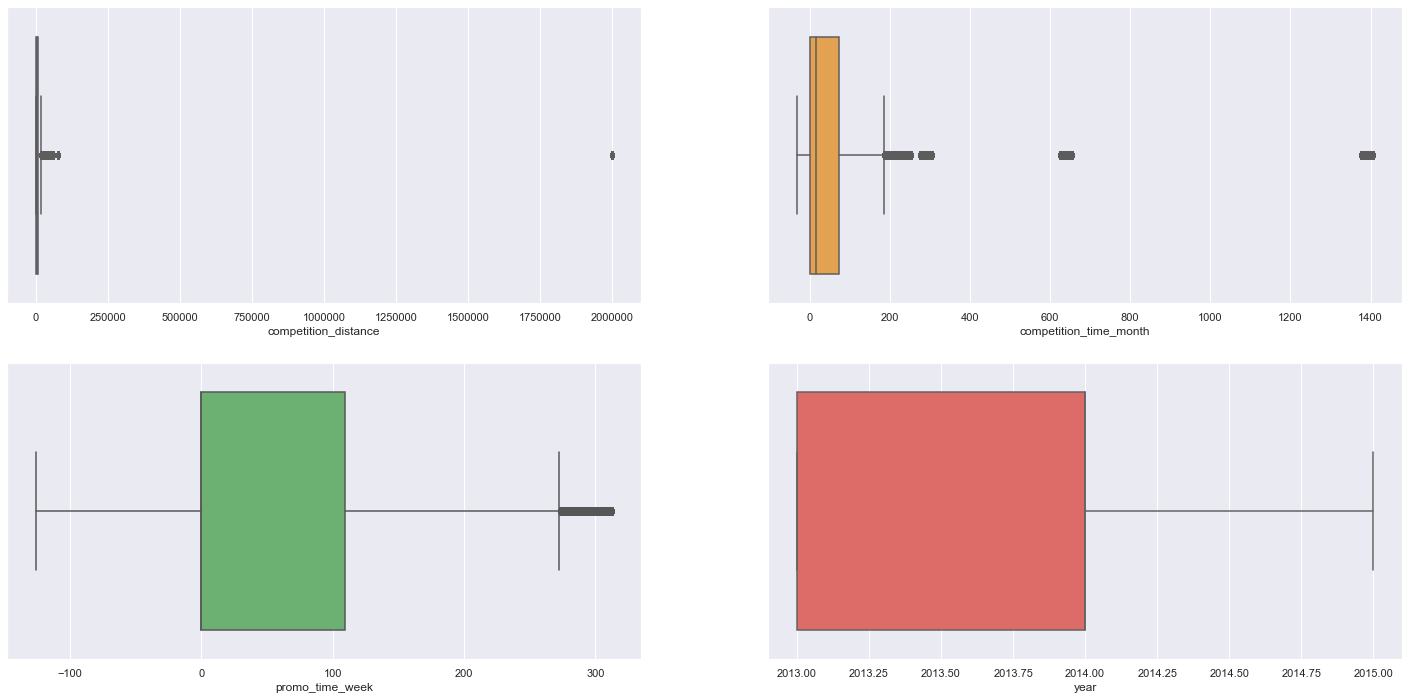

In [55]:
#boxplots
plt.subplot(2,2,1)
ax = sns.boxplot(df5['competition_distance'], color = blue)

plt.subplot(2,2,2)
ax = sns.boxplot(df5['competition_time_month'], color = orange)

plt.subplot(2,2,3)
ax = sns.boxplot(df5['promo_time_week'], color = green)

plt.subplot(2,2,4)
ax = sns.boxplot(df5['year'], color = red)

#saving figure
plt.savefig('../img/outliers.png')

- `competition_distance`: We'll use RobustScaler because there's a lot of outliers.
- `competition_time_month`: We'll use RobustScaler because there's a lot of outliers.
- `promo_time_week`: We'll use MinMaxScaler because there aren't many outliers.
- `year`:We'll use MinMaxScaler because there's no outlier.

In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
os.makedirs(os.path.dirname('/home/gutto/Projects/rossmann_store_sales/parameter/competition_distance_scaler.pkl'), exist_ok = True)
with open('/home/gutto/Projects/rossmann_store_sales/parameter/competition_distance_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))

### 5.3 Transformation

#### 5.3.1 Encoding

**Label Enconder**

LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n-1. It can be used to transform non-numerical labels to numerical labels.

**One Hot Encoder**

One Hot Encoder transforms each categorical feature into binary feature, with one of them 1, and all others 0.

**Ordinal Encoder**

OrdinalEncoder transforms each categorical feature to one new feature of integers as being ordered.

In [57]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/home/gutto/Projects/rossmann_store_sales/parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2 Response variable transformation

In transforming the response variable, we approximate the distribution of the response variable as close as possible to a normal distribution. This is used because machine learning algorithms are modelling using an assumption, the data is normally distributed.

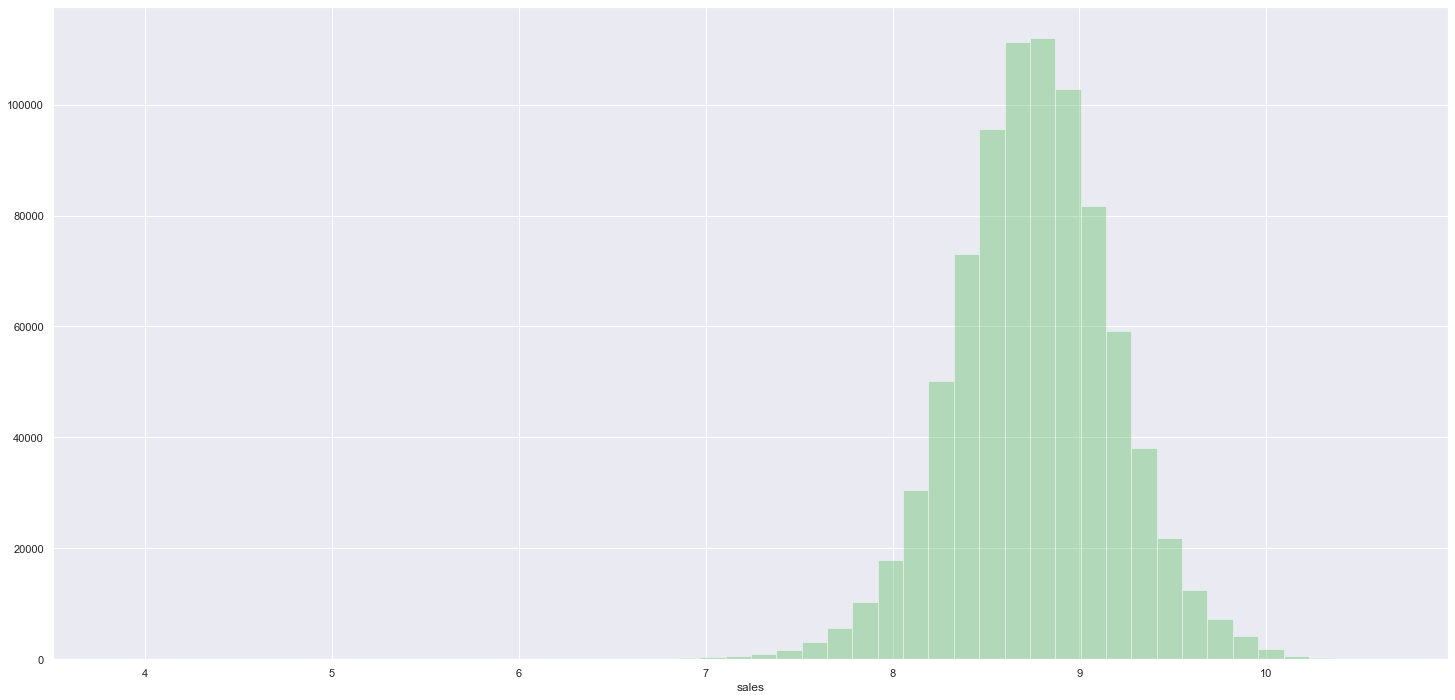

In [58]:
df5['sales'] = np.log1p(df5['sales'])
ax = sns.distplot(df5['sales'], color = green, kde = False)

#### 5.3.3 Nature transformation

In nature transformation, we have to bring the true nature of the data to the dataset. In this case, the variable 'month' is cyclical and has to be transformed, as the months are repeated each year that begins. But for that, we don't just list the months 1 to 12 because we lost the sense of cycle due to the different distances.

In [59]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(
    lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(
    lambda x: np.cos(x * (2. * np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(
    lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(
    lambda x: np.cos(x * (2. * np.pi / 52)))

## 6.0 FEATURE SELECTION

### 6.1 Checkpoint

In [60]:
df6 = df5.copy()

### 6.2 Train and Test Split 

In [61]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.569,1,1,2,1,-0.171,9,2008,0,31,2015,0,1.000,7,31,31,2015-30,2008-09-01,0.919,2015-07-27,0.287,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823
1,2,5,2015-07-31,8.710,1,1,0,1,-0.284,11,2007,1,13,2010,1,1.000,7,31,31,2015-30,2007-11-01,1.054,2010-03-22,0.923,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823
2,3,5,2015-07-31,9.026,1,1,0,1,1.903,12,2006,1,14,2011,1,1.000,7,31,31,2015-30,2006-12-01,1.203,2011-03-28,0.802,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823
3,4,5,2015-07-31,9.547,1,1,2,3,-0.276,9,2009,0,31,2015,0,1.000,7,31,31,2015-30,2009-09-01,0.743,2015-07-27,0.287,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823
4,5,5,2015-07-31,8.481,1,1,0,1,4.448,4,2015,0,31,2015,0,1.000,7,31,31,2015-30,2015-04-01,-0.162,2015-07-27,0.287,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823


In [62]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [63]:
# Using the last 6 weeks in the dataset to use as test
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6 * 7)

Timestamp('2015-06-19 00:00:00')

In [64]:
#train data
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

# ---
print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.3 Boruta as Feature Selector

In [65]:
'''
# this phase took 1h to be done, to reduce the code execution time, this part of the code is commented*

# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

# define boruta
boruta = BorutaPy (rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)
'''

"\n# this phase took 1h to be done, to reduce the code execution time, this part of the code is commented*\n\n# training and test dataset for Boruta\nX_train_n = X_train.drop(['date', 'sales'], axis = 1).values\ny_train_n = y_train.values.ravel()\n\n# define RandomForestRegressor\nrf = RandomForestRegressor(n_jobs = -1)\n\n# define boruta\nboruta = BorutaPy (rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)\n"

#### 6.3.1 Best features selected

In [66]:
'''
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = X_train.drop(['date', 'sales'], axis = 1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
'''

"\ncols_selected = boruta.support_.tolist()\n\n# best features\nx_train_fs = X_train.drop(['date', 'sales'], axis = 1)\ncols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()\n\n# not selected boruta\ncols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))\n"

In [67]:
# cols_selected_boruta

In [68]:
# cols_not_selected_boruta

### 6.4 Manual Feature Selection

In [69]:
cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

# columns to add
add_important_features = ['date', 'sales']

# cols_selected extended
cols_selected_full = cols_selected.copy()
cols_selected_full.extend(add_important_features)

# ---
cols_not_selected = [
    'is_promo',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'year'
]

## 7.0 MACHINE LEARNING MODELS

- **Tasks**
    - Apply Machine Learning Models
        - Average Model
        - Linear Regression
        - Lasso
        - Random Forest Regressor
        - XGBooster Regressor
    - Apply Machine Learning Models with Cross-Validation
        - Linear Regression
        - Lasso
        - Random Forest Regressor
        - XGBooster Regressor

### 7.1 Train and Test in Columns Selected

In [70]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

# time series data preparation
x_train_ts = X_train[cols_selected_full]

### 7.2 Average Model

In [71]:
# model
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(
       columns = {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model name,MAE,MAPE,RMSE
0,Average model,1366.128,0.452,1854.263


### 7.3 Models Without Cross-Validation

#### 7.3.1 Linear regression model

In [72]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression,1865.277,0.293,2678.012


#### 7.3.2 Lasso model

In [73]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1892.399,0.290,2752.314


#### 7.3.3 Random forest regressor model

In [74]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)
# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.810,0.100,1011.300


#### 7.3.4 XGBooster regressor model

In [75]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators= 100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBooster Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model name,MAE,MAPE,RMSE
0,XGBooster Regressor,891.738,0.129,1312.013


### 7.4 Models With Cross-Validation

Cross-Validation is a method applied in machine learning models to estimate the skill of a ML model with unseen data. Using a limited sample to estimate how the model perform when used to make predictions with not used data during the training.

#### 7.4.1 Linear regression model

In [76]:
lr_result_cv = cross_validation(x_train_ts, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72


#### 7.4.2 Lasso model

In [77]:
lrr_result_cv = cross_validation(x_train_ts, 5, 'Linear Regression Regularized', lrr, verbose = False) 
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,2117.66 +/- 340.94,0.29 +/- 0.01,3061.89 +/- 503.23


#### 7.4.3 Random forest regressor model

In [78]:
rf_result_cv = cross_validation(x_train_ts, 5, 'Random Forest Regressor', rf, verbose = False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67


#### 7.4.4 XGBooster regressor model

In [79]:
xgb_result_cv = cross_validation(x_train_ts, 5, 'XGBooster Regressor Model', model_xgb, verbose = False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBooster Regressor Model,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33


### 7.5 Compare Model Performance

#### 7.5.1 Single performance

In [80]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model name,MAE,MAPE,RMSE
0,XGBooster Regressor,891.738,0.129,1312.013
0,Average model,1366.128,0.452,1854.263
0,Linear Regression,1865.277,0.293,2678.012
0,Linear Regression Regularized,1892.399,0.290,2752.314


#### 7.5.2 Real performance

In [81]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBooster Regressor Model,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72
0,Linear Regression Regularized,2117.66 +/- 340.94,0.29 +/- 0.01,3061.89 +/- 503.23


## 8.0 HYPERPARAMETER FINE TUNING

- **Task**
    - Set optimal hyperparameters for the choosen algorithm.

We have different approaches to select better values in hyperparameter fine tuning process, the most used are:

- Random search
- Grid search
- Bayesian optimization

In this project, we'll use random search because is the fastest way to select better hyperparameters.


### 8.1 Random Search

In [82]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.02, 0.03],
#    'max_depth': [3, 7, 9],
#    'subsample': [0.1, 0.3, 0.7],
#    'colsample_bytree': [0.3, 0.6, 0.9],
#    'min_child_weight': [3, 8, 12, 15]
#        }
#
#MAX_EVAL = 5

In [83]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: random.sample( v, 1 )[0] for k, v in param.items()}
#     print(hp)

#     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])

#     # performance
#     result = cross_validation(x_train_ts, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result])

# final_result

The best result found was {'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}

### 8.2 Final Model

In [84]:
param_tuned = {
    'n_estimators': 1500,
'eta': 0.01,
'max_depth': 9,
'subsample': 0.1,
'colsample_bytree': 0.7,
'min_child_weight': 15 
}

In [85]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'], 
                                   max_depth=param_tuned['max_depth'], 
                                   subsample=param_tuned['subsample'],
                                   colsample_bytee=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,661.335,0.096,966.749


## 9.0. ERROR INTERPRETATION

- **Task**
    - Convert machine learning model result to bussiness result

In [86]:
df9 = X_test[cols_selected_full]

# change scale to original
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1. Business Performance

In [87]:
# sum of predictions
df9a = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

In [88]:
# merge
df9_aux = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df9b = pd.merge(df9a, df9_aux, how = 'inner', on = 'store')

# best and worst scenarios
df9b['worst_scenario'] = df9b['predictions'] - df9b['MAE']
df9b['best_scenario'] = df9b['predictions'] + df9b['MAE']

# result
df9b = df9b[['store', 'predictions', 'best_scenario', 'worst_scenario', 'MAE', 'MAPE']]

In [89]:
df9b.sort_values("MAPE").head()

,store,predictions,best_scenario,worst_scenario,MAE,MAPE
732,733,625576.250,626279.399,624873.101,703.149,0.048
171,172,246060.062,246436.998,245683.127,376.936,0.053
1096,1097,440702.219,441306.435,440098.003,604.216,0.056
258,259,529149.750,529847.256,528452.244,697.506,0.056
118,119,210115.234,210451.358,209779.110,336.124,0.056


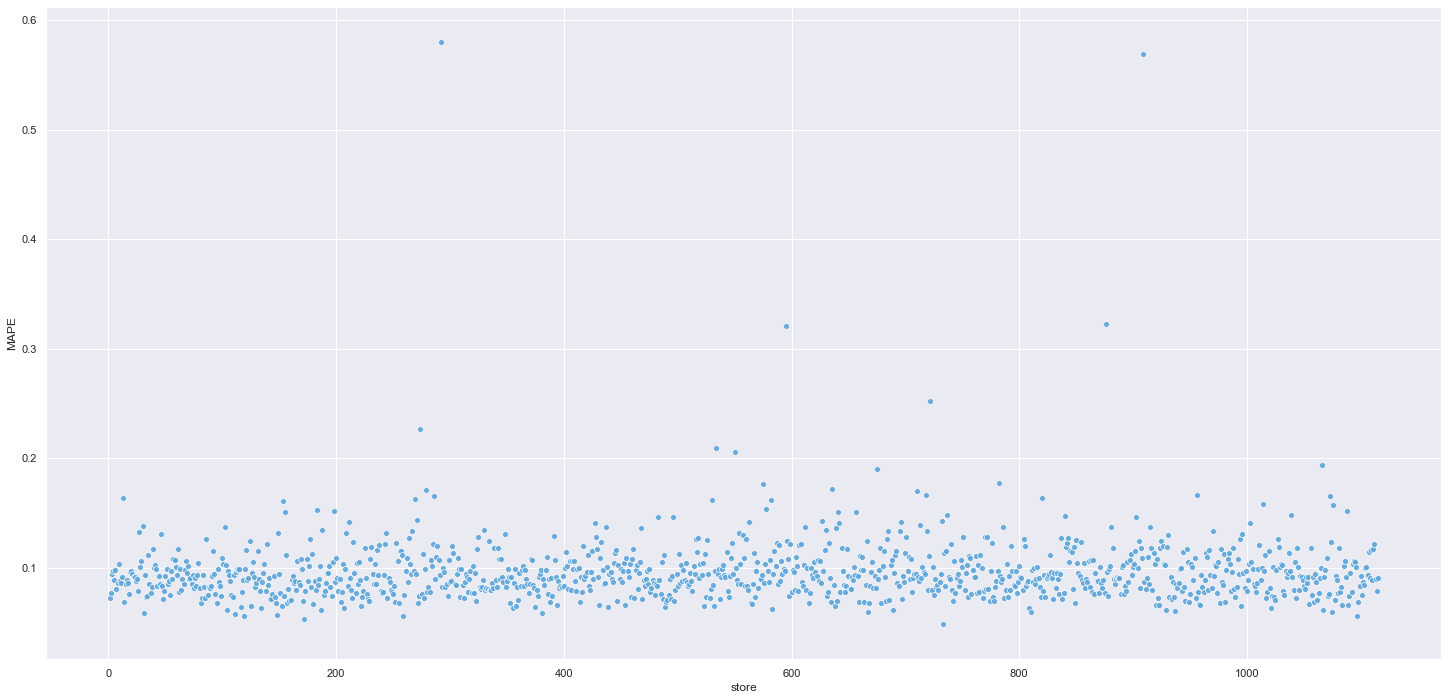

In [90]:
ax = sns.scatterplot(x = 'store', y = 'MAPE', data = df9b, color = blue, alpha = 0.9 );

#saving figure
plt.savefig('../img/bussiness_performance.png')

Stores with higher MAPE value are too dificult to predict, they need more attention to make decisions.

### 9.2. Total Performance

In [91]:
df9c = df9b[['predictions', 'worst_scenario', 'best_scenario']]
df9c.columns = ['Predictions', 'Worst scenario', 'Best scenario']
df9c = df9c[['Predictions', 'Worst scenario', 'Best scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index':'Scenario', 0:'Values'})
df9c['Values'] = df9c['Values'].map('${:,.2f}'.format)
df9c

,Scenario,Values
0,Predictions,"$274,491,136.00"
1,Worst scenario,"$273,749,324.67"
2,Best scenario,"$275,232,945.67"


### 9.3. Machine Learning Performance

In [92]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

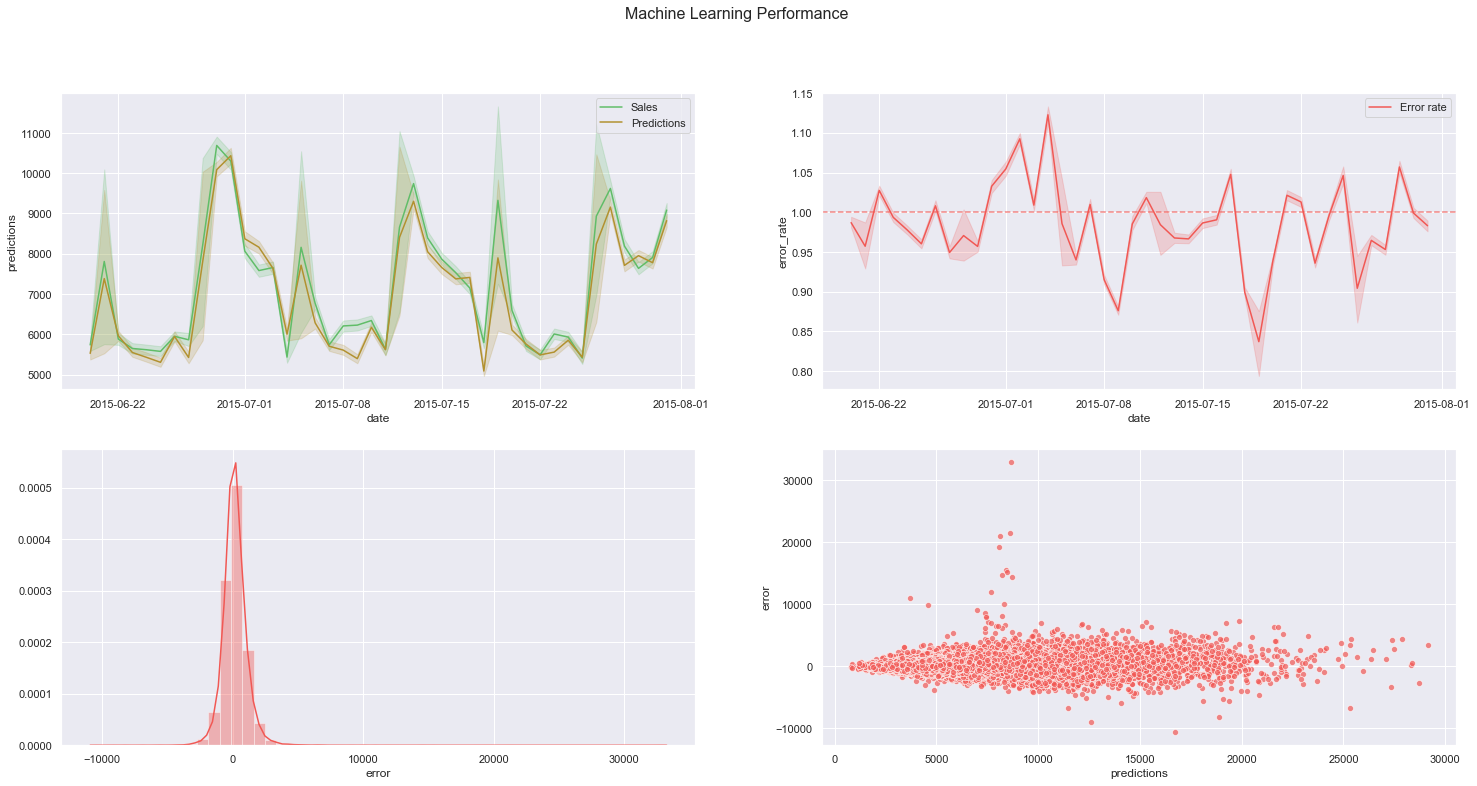

In [93]:
fig, ax = plt.subplots()
fig.suptitle('Machine Learning Performance', fontsize = 16)


plt.subplot(2, 2, 1)
ax = sns.lineplot(x = 'date', y = 'sales', data = df9, color = green, label = 'Sales' )
ax = sns.lineplot(x = 'date', y ='predictions', data = df9, color = brown, label = 'Predictions');

plt.subplot(2, 2, 2 )
ax = sns.lineplot(x = 'date', y = 'error_rate', data = df9, color = red, label = 'Error rate')
ax = plt.axhline(1, linestyle = '--', color = red, alpha = 0.7);

plt.subplot(2, 2, 3)
ax = sns.distplot(df9['error'], color = red);

plt.subplot(2, 2, 4)
ax = sns.scatterplot(df9['predictions'], df9['error'], color = red, alpha = 0.7);

#saving figure
plt.savefig('../img/ml_performance.png')

- Lineplot: We can see that the predictions of our model is close to the real value for sales. On the second one, the error rate has some variance.

- Distplot: Observing the histogram, the error distribution is similar to a normal distribution, that's good.

- Scatterplot: There are some stores with higher error in the points that seems like a horizontal tube, this means that there are a variation rate in the error.

## 10.0. DEPLOY MODEL TO PRODUCTION

In [94]:
# saving trained model
pickle.dump(model_xgb_tuned, open ("/home/gutto/Projects/rossmann_store_sales/model/model_rossmann.pkl", 'wb'))

### 10.1. Rossmann Class

In [95]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime as dt

class Rossmann(object):
    def __init__(self):
        self.home_path='/home/gutto/Projects/rossmann_store_sales/'
        self.competition_distance_scaler    = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
    
    
    def data_cleaning(self, df1):
        ### 1.2 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        #using the snakecase type
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new

        ### 1.4 Data Types
        #changing the date type from object to datetime
        df1['date'] = pd.to_datetime(df1['date'])

        ### 1.6 Fillout missing values
        # competition_distance
        # for complete the NaN elements, just apply a lambda function with a value > df1['competition_distance'].max()
        df1['competition_distance'] = df1['competition_distance'].apply(
            lambda x: 2000000.0 if math.isnan(x) else x)

        # competition_open_since_month
        # change the NaN elements to date
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(
            x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        # equal to competition_since_month
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
            x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(
            x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
            x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        #Changing names of month to numbers makes the manipulation easier
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',
                     7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        #there's a list, use .map instead of .apply
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ### 1.7 Change Types
        #converting competition_open_since_month, competition_open_since_year, promo2_since_week, promo2_since_year  from float to int
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
            int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
            int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering(self, df2):
        ### 2.5 Feature Engineering To Validate Our Hypothesis
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #  year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: dt.datetime(
            year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = (
            (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(
            str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: dt.datetime.strptime(
            x + '-1', '%Y-%W-%w') - dt.timedelta(days=7))
        df2['promo_time_week'] = (
            (df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(
            lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(
            lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ### 3.2 Filtering Rows
        df2 = df2[df2['open'] != 0]

        ### 3.3 Filtering Columns
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):
        ### 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ### 5.3 Transformation
        #### 5.3.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        #### 5.3.3 Nature transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(
            lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(
            lambda x: np.cos(x * (2. * np.pi / 7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(
            lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(
            lambda x: np.cos(x * (2. * np.pi / 52)))
        
        #columns selected by boruta
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 
                         'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                         'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

### 10.2. API Handler

In [ ]:
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
import pandas as pd
import pickle

# loading model
model = pickle.load(open ('/home/gutto/Projects/rossmann_store_sales/model/model_rossmann.pkl', 'rb'))

# initializa API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there's data
        # unique example
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index = [0])
        
        # multiple example
        else:        
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
    
    
        # instance rossmann class
        pipeline = Rossmann()
    
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
        
        
if __name__ == '__main__':
    app.run('0.0.0.0')

### 10.2. API Tester

In [127]:
df10 = pd.read_csv('../data/test.csv')

# merge test + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([12, 15, 17, 20])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [128]:
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
7,12,4,2015-09-17,1.000,1,0,0,a,c,1070.000,NaN,NaN,1,13.000,2010.000,"Jan,Apr,Jul,Oct"
10,15,4,2015-09-17,1.000,1,0,0,d,c,4110.000,3.000,2010.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct"
13,20,4,2015-09-17,1.000,1,0,0,d,a,2340.000,5.000,2009.000,1,40.000,2014.000,"Jan,Apr,Jul,Oct"
863,12,3,2015-09-16,1.000,1,0,0,a,c,1070.000,NaN,NaN,1,13.000,2010.000,"Jan,Apr,Jul,Oct"
866,15,3,2015-09-16,1.000,1,0,0,d,c,4110.000,3.000,2010.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct"


In [129]:
# convert DataFrame to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [130]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print('Status code {}'.format(r.status_code))

Status code 200


In [131]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys())

In [132]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.000,1,regular_day,0,a,extended,1070.000,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,4874.424
1,15,4,2015-09-17T00:00:00.000Z,1.000,1,regular_day,0,d,extended,4110.000,3,2010,1,14,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2010-03-01T00:00:00.000Z,67,2011-03-28T00:00:00.000Z,233,6583.626
2,20,4,2015-09-17T00:00:00.000Z,1.000,1,regular_day,0,d,basic,2340.000,5,2009,1,40,2014,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,5721.836
3,12,3,2015-09-16T00:00:00.000Z,1.000,1,regular_day,0,a,extended,1070.000,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,5162.322
4,15,3,2015-09-16T00:00:00.000Z,1.000,1,regular_day,0,d,extended,4110.000,3,2010,1,14,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2010-03-01T00:00:00.000Z,67,2011-03-28T00:00:00.000Z,233,6304.936


In [134]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell ${:,.2f} in the next 6 weeks!'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 12 will sell $215,415.19 in the next 6 weeks!
Store Number 15 will sell $270,155.64 in the next 6 weeks!
Store Number 20 will sell $242,018.06 in the next 6 weeks!
